In [31]:
save_path = "/Users/maori2/SchoenbaumLab Dropbox/ido maor/Mac/Documents/Lab/data/behavior/Saved_analysis/All_dataset"

import scipy.io as sio
import scipy.stats as sts
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from scipy import stats
from scipy.stats import mannwhitneyu

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from scipy.spatial.distance import mahalanobis as mahal
from scipy.spatial.distance import seuclidean, canberra, euclidean, cosine, minkowski
from scipy.linalg import pinvh

from matplotlib.gridspec import GridSpec
import statsmodels.api as sm
from scipy.spatial.distance import cosine

import scipy.io
from zetapy import ifr, zetatest, zetatstest, zetatest2, zetatstest2, plotzeta, plottszeta, plotzeta2, plottszeta2
from scipy.stats import norm
from scipy.signal import convolve
import time
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf

from sklearn import svm
from sklearn.model_selection import cross_val_predict, cross_val_score, LeaveOneOut
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from scipy.stats import sem
from sklearn import set_config
from sklearn.model_selection import permutation_test_score

from sklearn.linear_model import LinearRegression

#import umap.umap_ as umap
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]

plt.rcParams['axes.grid'] = False        # Disable grid lines globally
plt.rcParams['axes.linewidth'] = 1    # Make axes thicker
plt.rcParams['axes.edgecolor'] = 'black' # Make axes darker

In [3]:
import umap.umap_ as umap


ImportError: cannot import name 'tarfile' from 'backports' (/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/backports/__init__.py)

In [33]:
def analyze_behave(Analysis_table):

    Analysis_table_f = Analysis_table[(Analysis_table.correction_trial==0) & (Analysis_table.odor_unpoke_early==0)].reset_index()
    max_unpoke = 5000 #trim the sampling odor windo to 5 sec
    Analysis_table_f.loc[Analysis_table_f.odor_unpoke-Analysis_table_f.odor_poke>max_unpoke,'odor_unpoke']=Analysis_table_f.odor_poke+max_unpoke
    Analysis_table_f.loc[:,'pre_trial'] = Analysis_table_f['light_on'] - 1000

    y = np.array(Analysis_table_f.go_nogo)
    s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])

    HitRate_cdnm = (y[cdnm_rule==1].astype(bool)==1)
    FaRate_cdnm = (y[cdnm_rule==0].astype(bool)==1)
    HitRate_disc =(y[disc_rule==1].astype(bool)==1)
    FaRate_disc = (y[disc_rule==0].astype(bool)==1)

    correct_cdnm = (np.average(HitRate_cdnm)+(1-np.average(FaRate_cdnm)))/2
    correct_disc = (np.average(HitRate_disc)+(1-np.average(FaRate_disc)))/2

    def calculate_d_prime(hits, false_alarms):
        if hits == 0:
            hits = 0.01
        if false_alarms == 0:
            false_alarms = 0.01
        if hits == 1:
            hits = 1 - 0.01
        if false_alarms == 1:
            false_alarms = 1 - 0.01


        hits = np.array(hits)
        false_alarms = np.array(false_alarms)

        # z-scores
        hitZ = sts.norm.ppf(hits)
        faZ  = sts.norm.ppf(false_alarms)

        # d-prime
        dPrime = hitZ-faZ

        return dPrime

    def find_first_index(Analysis_table_f): # Custom function to find the first index in vehave_crit where Value = 1
        index = (Analysis_table_f['behave_crit'] == 1).idxmax()
        return index if not (index==0 or pd.isna(index)) else 500

    dPrime_cdnm = calculate_d_prime(np.average(HitRate_cdnm), np.average(FaRate_cdnm))
    dPrime_disc = calculate_d_prime(np.average(HitRate_disc), np.average(FaRate_disc))
    tr_to_crit = index

    Analysis_table_mod = Analysis_table_f.copy()

    Analysis_table_mod.loc[:,'cdnm_rule']=cdnm_rule
    Analysis_table_mod.loc[:,'disc_rule']=disc_rule
    Analysis_table_mod.loc[:,'time_to_poke']=Analysis_table_f['odor_poke']-Analysis_table_f['light_on']
    Analysis_table_mod.loc[:,'time_to_unpoke']=Analysis_table_f['odor_unpoke']-Analysis_table_f['odor_poke']
    Analysis_table_mod.loc[:,'time_to_water']=Analysis_table_f['water_poke']-Analysis_table_f['odor_poke']
    Analysis_table_mod.loc[:,'ITI']=Analysis_table_mod['light_on'].diff()
    Analysis_table_mod.loc[:,'odor_before']=s1[:,1]
    Analysis_table_mod.loc[0,'odor_before']=Analysis_table_mod.loc[1,'odor_before'] #puting the same odor on the first trial to avoide nans


    behave_dict = {
        "Analysis_table_mod":Analysis_table_mod,
        "correct_cdnm": correct_cdnm,
        "correct_disc": correct_disc,
        "dPrime_cdnm": dPrime_cdnm,
        "dPrime_disc": dPrime_disc,
        "tr_to_crit": tr_to_crit,
        "HitRate_cdnm": HitRate_cdnm,
        "FaRate_cdnm": FaRate_cdnm,
        "HitRate_disc":HitRate_disc,
        "FaRate_disc": FaRate_disc
    }
    return behave_dict

def calculate_d_prime(hits, false_alarms):
    if hits == 0:
        hits = 0.01
    if false_alarms == 0:
        false_alarms = 0.01
    if hits == 1:
        hits = 1 - 0.01
    if false_alarms == 1:
        false_alarms = 1 - 0.01


    hits = np.array(hits)
    false_alarms = np.array(false_alarms)

    # z-scores
    hitZ = sts.norm.ppf(hits)
    faZ  = sts.norm.ppf(false_alarms)

    # d-prime
    dPrime = hitZ-faZ

    return dPrime

def bin_performance(Analysis_table_f,  bin_num=4):
    y = np.array(Analysis_table_f.go_nogo)
    s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])

    cdnm_only = (cdnm_rule==1) & (disc_rule==0)
    disc_only = (cdnm_rule==0) & (disc_rule==1)

    HitRate_cdnm = (y[cdnm_rule==1].astype(bool)==1)
    FaRate_cdnm = (y[cdnm_rule==0].astype(bool)==1)
    HitRate_disc =(y[disc_rule==1].astype(bool)==1)
    FaRate_disc = (y[disc_rule==0].astype(bool)==1)

    HitRate_cdnm_only = (y[cdnm_only==1].astype(bool)==1)
    FaRate_cdnm_only =  (y[cdnm_only==0].astype(bool)==1)
    HitRate_disc_only = (y[disc_only==1].astype(bool)==1)
    FaRate_disc_only = (y[disc_only==0].astype(bool)==1)

    correct_cdnm_bin =[]
    correct_disc_bin = []
    dPrime_cdnm_bin =[]
    dPrime_disc_bin = []
    HitRate_cdnm_bin =[]
    FARate_cdnm_bin = []
    HitRate_disc_bin =[]
    FARate_disc_bin = []
    correct_cdnm_only_bin =[]
    correct_disc_only_bin = []

    hist, bin_edges_1 = np.histogram(np.arange(0, len(HitRate_cdnm)), bins=bin_num); bined_day_1 = np.floor(bin_edges_1).astype(int)
    hist, bin_edges_2 = np.histogram(np.arange(0, len(FaRate_cdnm)), bins=bin_num); bined_day_2 = np.floor(bin_edges_2).astype(int)
    hist, bin_edges_3 = np.histogram(np.arange(0, len(HitRate_disc)), bins=bin_num); bined_day_3 = np.floor(bin_edges_3).astype(int)
    hist, bin_edges_4 = np.histogram(np.arange(0, len(FaRate_disc)), bins=bin_num); bined_day_4 = np.floor(bin_edges_4).astype(int)

    hist, bin_edges_5 = np.histogram(np.arange(0, len(HitRate_cdnm_only)), bins=bin_num); bined_day_5 = np.floor(bin_edges_5).astype(int)
    hist, bin_edges_6 = np.histogram(np.arange(0, len(FaRate_cdnm_only)), bins=bin_num); bined_day_6 = np.floor(bin_edges_6).astype(int)
    hist, bin_edges_7 = np.histogram(np.arange(0, len(HitRate_disc_only)), bins=bin_num); bined_day_7 = np.floor(bin_edges_7).astype(int)
    hist, bin_edges_8 = np.histogram(np.arange(0, len(FaRate_disc_only)), bins=bin_num); bined_day_8 = np.floor(bin_edges_8).astype(int)

    for ii in range(len(bined_day_1) - 1):

        #correct_cdnm_bin.append(np.average(raw_correct_cdnm_rule[start_index1:end_index1]))
        #correct_disc_bin.append(np.average(raw_correct_disc_rule[start_index1:end_index1]))
        correct_cdnm_bin.append((np.average(HitRate_cdnm[bined_day_1[ii]:bined_day_1[ii+1]])+(1-np.average(FaRate_cdnm[bined_day_2[ii]:bined_day_2[ii+1]])))/2)
        correct_disc_bin.append((np.average(HitRate_disc[bined_day_3[ii]:bined_day_3[ii+1]])+(1-np.average(FaRate_disc[bined_day_4[ii]:bined_day_4[ii+1]])))/2)

        dPrime_cdnm_bin.append(calculate_d_prime(np.average(HitRate_cdnm[bined_day_1[ii]:bined_day_1[ii+1]]), np.average(FaRate_cdnm[bined_day_2[ii]:bined_day_2[ii+1]])))
        dPrime_disc_bin.append(calculate_d_prime(np.average(HitRate_disc[bined_day_3[ii]:bined_day_3[ii+1]]), np.average(FaRate_disc[bined_day_4[ii]:bined_day_4[ii+1]])))

        HitRate_cdnm_bin.append(np.average(HitRate_cdnm[bined_day_1[ii]:bined_day_1[ii+1]]))
        FARate_cdnm_bin.append(np.average(FaRate_cdnm[bined_day_2[ii]:bined_day_2[ii+1]]))
        HitRate_disc_bin.append(np.average(HitRate_disc[bined_day_3[ii]:bined_day_3[ii+1]]))
        FARate_disc_bin.append(np.average(FaRate_disc[bined_day_4[ii]:bined_day_4[ii+1]]))

        correct_cdnm_only_bin.append((np.average(HitRate_cdnm_only[bined_day_5[ii]:bined_day_5[ii+1]])+(1-np.average(FaRate_cdnm_only[bined_day_6[ii]:bined_day_6[ii+1]])))/2)
        correct_disc_only_bin.append((np.average(HitRate_disc_only[bined_day_7[ii]:bined_day_7[ii+1]])+(1-np.average(FaRate_disc_only[bined_day_8[ii]:bined_day_8[ii+1]])))/2)

    return correct_cdnm_bin,correct_disc_bin,dPrime_cdnm_bin,dPrime_disc_bin,HitRate_cdnm_bin,FARate_cdnm_bin,HitRate_disc_bin,FARate_disc_bin,correct_cdnm_only_bin,correct_disc_only_bin
def running_average_crossing_threshold(Table, Win, T, X):
    # Create logical variable 'A' where 'B' is 'Hit' or 'CR'
    Table['A'] = ((Table['score'] == 'Hit') | (Table['score'] == 'CR')).astype(int)

    # Calculate the running average of the column 'A' with a window size 'Win'
    Table['Running_Avg'] = Table['A'].rolling(window=Win).mean()

    # Determine when the running average crosses the threshold 'T'
    Table['Crossed_Threshold'] = (Table['Running_Avg'] > T).astype(int)

    # Find consecutive crossings of length X
    Table['Consecutive_Crossings'] = Table['Crossed_Threshold'].rolling(window=X).sum()

    # Determine where exactly the threshold is reached in X consecutive rows
    #crossing_points = (Table['Consecutive_Crossings'] >= X) & (Table['Crossed_Threshold'] == 1)
    crossing_points = Table[(Table['Consecutive_Crossings'] >= X) & (Table['Crossed_Threshold'] == 1)]

    # Find the first index where the condition is met
    first_crossing_index = crossing_points.index[0] if not crossing_points.empty else None


    return Table, first_crossing_index
#correct_cdnm_bin,correct_disc_bin,dPrime_cdnm_bin,dPrime_disc_bin,HitRate_cdnm_bin,FARate_cdnm_bin,HitRate_disc_bin,FARate_disc_bin,correct_cdnm_only_bin,correct_disc_only_bin = bin_performance(Analysis_table_f,  bin_num=10)
def divide_intervals(start_times, end_times, num_intervals):
    # Check if the input arrays have the same length
    if len(start_times) != len(end_times):
        raise ValueError("Input arrays must have the same length")

    # Calculate the duration of each interval
    interval_durations = (end_times - start_times) / num_intervals

    # Create a list to store the divided intervals
    divided_intervals = []

    # Iterate through each start and end time pair
    for start, end in zip(start_times, end_times):
        # Calculate the boundaries of each subinterval
        subinterval_boundaries = np.linspace(start, end, num_intervals + 1)

        divided_intervals.append(subinterval_boundaries)

    return divided_intervals

def calc_PETH_equal_bins (Analysis_table, spikeTime , event_start = 'odor_poke' , event_end = 'odor_unpoke' , bin_num = 5):
    start_times = np.array(Analysis_table[event_start])/1000
    end_times = np.array(Analysis_table[event_end])/1000

    time_intervals = divide_intervals(start_times, end_times, bin_num)
    ntrials=len(time_intervals)
    temp1=[]
    for (trial_idx, trial) in enumerate(time_intervals):
        binduration=np.round(np.diff(trial)[0],decimals=2)
        temp2=[]
        for (unit_idx, spikes_unit) in enumerate(spikeTime):
            spikeinds = spikes_unit[np.logical_and((spikes_unit >= trial[0]),(spikes_unit < trial[-1]))]
            spikes_bin =np.histogram(spikeinds,bins = trial)
            temp2.append((1/binduration)*spikes_bin[0])# moving to Hz - 08/15/2024
            #temp2.append(spikes_bin[0])
        temp1.append(np.array(temp2))
    spikes_all = np.array(temp1) # [Trials,units,bins]
    PETH = spikes_all.reshape((ntrials,-1))

    s1 = np.column_stack((Analysis_table.odor_ID,Analysis_table.odor_ID.shift(1,fill_value=np.nan),Analysis_table.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    #Analysis_table['vals_and_ID']=Analysis_table['odor_ID']+(cdnm_rule-1)*-100
    Analysis_table.loc[:, 'vals_and_ID'] = Analysis_table['odor_ID'].copy() + (cdnm_rule.copy()-1)*-100

    #Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID"]].copy()
    Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID","cdnm_rule","disc_rule"]].copy()

    Trials.loc[:,'odor_before'] = Analysis_table.odor_ID.shift(1,fill_value=np.nan).copy()


    return PETH, Trials, spikes_all


def calc_PETH(Analysis_table, spikeTime , events = ['light_on','odor_poke','odor_time','odor_unpoke'] , resp_win = (-.2, .4),binduration=.1):

    nbins = int((resp_win[1]-resp_win[0])/binduration)
    timebins=np.arange(resp_win[0],(resp_win[1]+binduration),binduration,dtype=float)
    nunits=spikeTime.size;
    temp=[]
    for (event_idx, event) in enumerate(events):
        stim_times = np.array(Analysis_table[event])
        stimulustimes = stim_times/1000; #moving to sec                
        ntrials=stimulustimes.size;
        temp1=[]
        for  (trial_idx, trial) in enumerate(stimulustimes):
            temp2=[]
            for (unit_idx, spikes_unit) in enumerate(spikeTime):
                spikeinds = spikes_unit[np.logical_and((spikes_unit >= (trial+resp_win[0])),(spikes_unit < (trial+resp_win[1])))]-trial
                spikes_bin =np.histogram(spikeinds,bins = timebins)
                temp2.append((1/binduration)*spikes_bin[0])# moving to Hz - 08/15/2024
            temp1.append(np.array(temp2))
        temp.append(np.array(temp1))
    spikes_all = np.array(temp)
    #PETH = spikes_all.reshape((ntrials,-1))
    PETH = np.swapaxes(spikes_all, 0, 1).reshape((ntrials,-1))

    s1 = np.column_stack((Analysis_table.odor_ID,Analysis_table.odor_ID.shift(1,fill_value=np.nan),Analysis_table.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    #Analysis_table['vals_and_ID']=Analysis_table['odor_ID']+(cdnm_rule-1)*-100
    Analysis_table.loc[:, 'vals_and_ID'] = Analysis_table['odor_ID'].copy() + (cdnm_rule.copy()-1)*-100

    #Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID"]].copy()
    Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID","cdnm_rule","disc_rule"]].copy()

    Trials.loc[:,'odor_before'] = Analysis_table.odor_ID.shift(1,fill_value=np.nan).copy()

    return PETH, Trials, spikes_all

def calc_responsivness(Analysis_table_f,spikeTime):
    PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime,events = ['odor_unpoke'] , resp_win = (-.5, 0)) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    spikes_all = np.squeeze(spikes_all)
    T_statistic_cdnm=[];P_value_cdnm=[];T_statistic_disc=[];P_value_disc=[];T_statistic_resp=[];P_value_resp=[]
    cell_num = spikes_all.shape[1]
    FR = np.mean(spikes_all,axis=2)
    trials_idx = Analysis_table_f.cdnm_rule == True; FR_cdnm_go = FR[trials_idx,:]
    trials_idx = Analysis_table_f.cdnm_rule == False; FR_cdnm_nogo = FR[trials_idx,:]
    trials_idx = Analysis_table_f.disc_rule == True; FR_disc_go = FR[trials_idx,:]
    trials_idx = Analysis_table_f.disc_rule == False; FR_disc_nogo = FR[trials_idx,:]
    PETH, Trials, spikes_all_spont = calc_PETH(Analysis_table_f, spikeTime,events = ['light_on'] , resp_win = (-1, -.5)) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    spikes_all_spont = np.squeeze(spikes_all_spont)
    FR_spont = np.mean(spikes_all_spont,axis=2)

    for i in range(cell_num):
        t_statistic, p_value = ttest_ind(FR_cdnm_go[:,i], FR_cdnm_nogo[:,i])
        T_statistic_cdnm.append(t_statistic); P_value_cdnm.append(p_value)
        t_statistic, p_value = ttest_ind(FR_disc_go[:,i], FR_disc_nogo[:,i])
        T_statistic_disc.append(t_statistic); P_value_disc.append(p_value)
        t_statistic, p_value = ttest_rel(FR[:,i], FR_spont[:,i])
        T_statistic_resp.append(t_statistic); P_value_resp.append(p_value)


    responsiveness = pd.DataFrame({'FR_all':np.mean(FR[:,:],axis=0),'FR_spont':np.mean(FR_spont[:,:],axis=0),'FR_spont_std':np.std(FR_spont[:,:],axis=0),'FR_cdnm_go':np.mean(FR_cdnm_go,axis=0),'FR_cdnm_nogo':np.mean(FR_cdnm_nogo,axis=0),'FR_disc_go':np.mean(FR_disc_go,axis=0),'FR_disc_nogo':np.mean(FR_disc_nogo,axis=0),
                                   'T_statistic_cdnm':np.array(T_statistic_cdnm),'P_value_cdnm':np.array(P_value_cdnm),'T_statistic_disc':np.array(T_statistic_disc),'P_value_disc':np.array(P_value_disc),'T_statistic_resp':np.array(T_statistic_resp),'P_value_resp':np.array(P_value_resp)})
    return responsiveness

# 2)Dimensionality reduction

def runPCA(PETH,n_components=50):
    X = PETH[:,:]
    pca = PCA(n_components=n_components)
    H = pca.fit(X)  # Reconstruct signals based on orthogonal components
    Y = H.components_
    Y.shape # Y: NXT
    V_pca = pca.fit_transform(X)
    V_pca.shape #V:MXN (the Eigenvectors)
    exp_var = pca.explained_variance_ratio_

    return V_pca, exp_var

def run_Similarity(V_pca,Trials):

    u_vals = np.sort(pd.unique(Trials["vals_and_ID"]))
    av_LDA = np.empty([u_vals.shape[0],V_pca.shape[1]])
    for val_id, val in enumerate(u_vals):
        av_LDA [val_id,:] = np.mean(V_pca[Trials["vals_and_ID"]==val,:],0)
    cm = np.zeros([av_LDA.shape[0],av_LDA.shape[0]])

    for i, LDA_i in enumerate(av_LDA):
        for j, LDA_j in enumerate(av_LDA):
            cm[i,j] =  cosine(LDA_i, LDA_j)

    return  av_LDA, cm

def run_LDA(B,Trials):

    clf = LinearDiscriminantAnalysis(solver = 'svd',store_covariance=True)
    LDA_transformed = clf.fit(B, Trials["vals_and_ID"])
    # !!!!!!!!!!!!!!!
    LDA_coef = LDA_transformed.coef_ #
    B_LDA = np.dot( B,LDA_coef.transpose())
    #!!!!!!!!!!!!!!!
    B_LDA.shape # MXN
    LDA_exp_var = LDA_transformed.explained_variance_ratio_
    u_vals = np.sort(pd.unique(Trials["vals_and_ID"]))
    av_LDA = np.empty([u_vals.shape[0],B_LDA.shape[1]])
    for val_id, val in enumerate(u_vals):
        av_LDA [val_id,:] = np.mean(B_LDA[Trials["vals_and_ID"]==val,:],0)
    #av_LDA = av_LDA
    cm = np.zeros([av_LDA.shape[0],av_LDA.shape[0]])
    c_m = np.cov(av_LDA, rowvar=False)
    #C_inv = np.linalg.inv(c_m)
    var_i = np.var(B_LDA,axis = 0)

    for i, LDA_i in enumerate(av_LDA):
        for j, LDA_j in enumerate(av_LDA):
            cov = np.cov(LDA_i,LDA_j)
            #C_inv = np.linalg.inv(cov)
            #cm[i,j] = mahal(LDA_i, LDA_j, C_inv)
            #cm[i,j] = euclidean(LDA_i, LDA_j)
            cm[i,j] =  cosine(LDA_i, LDA_j)

    return B_LDA, av_LDA, cm, LDA_exp_var, LDA_transformed, LDA_coef

def calc_PETH_with_baseline(Analysis_table, spikeTime, events = ['odor_unpoke'],resp_win = (-2, 2), binduration = .05):

    nbins = int((resp_win[1]-resp_win[0])/binduration)
    timebins=np.arange(resp_win[0],(resp_win[1]+binduration),binduration,dtype=float)
    nunits=spikeTime.size;

    basline_time = np.array(Analysis_table['light_on'] - 1000)/1000 #moving to sec   


    temp=[]
    base=[]
    for (event_idx, event) in enumerate(events):
        stim_times = np.array(Analysis_table[event])
        stimulustimes = stim_times/1000; #moving to sec                
        ntrials=stimulustimes.size;
        temp1=[]
        base1=[]
        for  (trial_idx, trial) in enumerate(stimulustimes):
            temp2=[]
            base2=[]
            for (unit_idx, spikes_unit) in enumerate(spikeTime):
                spikeinds = spikes_unit[np.logical_and((spikes_unit >= (trial+resp_win[0])),(spikes_unit < (trial+resp_win[1])))]-trial
                spikeinds_baseline = spikes_unit[np.logical_and((spikes_unit >= basline_time[trial_idx]),(spikes_unit < (basline_time[trial_idx]+.5)))]-basline_time[trial_idx]
                baseline_fr = len(spikeinds_baseline)*2 #moving to Hz
                spikes_bin =np.histogram(spikeinds,bins = timebins)
                #temp2.append((1/binduration)*spikes_bin[0] - baseline_fr) # moving to Hz and substracting basline
                temp2.append((1/binduration)*spikes_bin[0]) # moving to Hz
                base2.append(baseline_fr)
            temp1.append(np.array(temp2))
            base1.append(np.array(base2))
        temp.append(np.array(temp1))
        base.append(np.array(base1))
    spikes_all = np.array(temp)
    baseline_all = np.array(base)
    PETH = np.swapaxes(spikes_all, 0, 1).reshape((ntrials,-1))


    s1 = np.column_stack((Analysis_table.odor_ID,Analysis_table.odor_ID.shift(1,fill_value=np.nan),Analysis_table.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    Analysis_table.loc[:,'vals_and_ID']=Analysis_table.loc[:,'odor_ID']+(cdnm_rule-1)*-100


    Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID","cdnm_rule","disc_rule"]]
    Trials.loc[:,'odor_before'] = Analysis_table.odor_ID.shift(1,fill_value=np.nan)

    return PETH, Trials, spikes_all,baseline_all

def calc_zScore (spikes_all,baseline_all,trials_idx):
    baseline_mean = np.mean(np.squeeze(baseline_all)[trials_idx,:],0)
    baseline_std = np.std(np.squeeze(baseline_all)[trials_idx,:],0)
    baseline_std[baseline_std==0] = 1 #to overcome dividing by zero
    nbins = spikes_all.shape[3]
    temp = baseline_mean[:, np.newaxis]# Add a new axis using np.newaxis
    replicated_baseline_mean = np.tile(temp, (1, nbins))# Replicate the vector along the new axis using np.tile
    temp = baseline_std[:, np.newaxis]# Add a new axis using np.newaxis
    replicated_baseline_std = np.tile(temp, (1, nbins))# Replicate the vector along the new axis using np.tile
    mean_fr = np.mean(np.squeeze(spikes_all[:,trials_idx,:,:]),0)
    z_score = (mean_fr - replicated_baseline_mean)/replicated_baseline_std

    return z_score


def prep_for_svm(Analysis_table_f,spikeTime):


    PETH, Trials, spikes_all = calc_PETH_equal_bins (Analysis_table_f, spikeTime , event_start = 'odor_poke' , event_end = 'odor_unpoke' , bin_num = 5)
    PETH = np.squeeze(spikes_all.mean(axis = 2)) # mean over all bins

    # PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime , events = ['light_on','odor_poke','odor_time','odor_unpoke'] , resp_win = (-.2, .4)) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    # [PETH, temp] = runPCA(PETH)

    newDF_temp = Analysis_table_f.loc[:,["odor_ID","odor_value","go_nogo","score","cdnm_rule","disc_rule","vals_and_ID","odor_before"]]

    df1_reset = pd.DataFrame(PETH).reset_index(drop=True)
    newDF = pd.concat([df1_reset, newDF_temp], axis=1)     # Concatenate along the x-axis (columns)

    PETH, Trials, spikes_all_before = calc_PETH(Analysis_table_f, spikeTime , events = ['light_on'] , resp_win = (0, .3)) #Trials by events X bins X units (number of neurons × 4 epochs × 3 time points)
    PETH, Trials, spikes_all_response = calc_PETH(Analysis_table_f, spikeTime , events = ['odor_unpoke'] , resp_win = (0, .3)) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    spikes_all_concat = np.concatenate((np.squeeze(spikes_all_before),np.squeeze(spikes_all),np.squeeze(spikes_all_response)),axis=2)

    newDF_bins=[]
    for i in range(spikes_all_concat.shape[2]): #run over differnt bins
        PETH = np.squeeze(spikes_all_concat[:,:,i]) # select a specific bin
        df1_reset = pd.DataFrame(PETH).reset_index(drop=True)
        newDF_bins.append( pd.concat([df1_reset, newDF_temp], axis=1))

    return newDF, newDF_bins

def prep_for_svm_pca(Analysis_table_f,spikeTime):


    #     PETH, Trials, spikes_all = calc_PETH_equal_bins (Analysis_table_f, spikeTime , event_start = 'odor_poke' , event_end = 'odor_unpoke' , bin_num = 5)
    #     PETH = np.squeeze(spikes_all.mean(axis = 2)) # mean over all bins

    PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime , events = ['light_on','odor_poke','odor_time','odor_unpoke'] , resp_win = (-.2, .4),binduration=.1) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    [PETH, temp] = runPCA(PETH)

    newDF_temp = Analysis_table_f.loc[:,["odor_ID","odor_value","go_nogo","score","cdnm_rule","disc_rule","vals_and_ID","odor_before"]]

    df1_reset = pd.DataFrame(PETH).reset_index(drop=True)
    # Concatenate along the x-axis (columns)
    newDF = pd.concat([df1_reset, newDF_temp], axis=1)

    return newDF



def calc_svm(newDF,decode_var = 'cdnm_rule',reg_var = 'go_nogo'):

    #dilute the dataframe so number of trial repetiations will be equal to the min number
    class_IDs, counts = np.unique(newDF[decode_var],return_counts=True)
    min_reps = np.min(counts)
    df = pd.DataFrame()
    for class_ID in class_IDs:
        df = pd.concat([df, newDF[newDF[decode_var] == class_ID].tail(min_reps)])

    #seperate the dataset into response variable and feature variables:

    X = df.drop(["odor_ID","odor_value","go_nogo","score","cdnm_rule","disc_rule","vals_and_ID","odor_before"],axis=1)
    y = df[decode_var]

    # SVM Classifier
    clf = make_pipeline(StandardScaler(), svm.SVC())

    y_pred = cross_val_predict(clf, X, np.ravel(y), cv=LeaveOneOut())

    cm = confusion_matrix(y, y_pred,normalize='true')
    # score_m = cross_val_score(clf, X, y, cv=LeaveOneOut()).mean()
    # score_s = cross_val_score(clf, X, y, cv=LeaveOneOut()).std()

    score_m = np.round(cross_val_score(clf, X, y, cv=LeaveOneOut(),scoring='accuracy').mean(),2)
    score_s = np.round(cross_val_score(clf, X, y, cv=LeaveOneOut(),scoring='accuracy').std(),2)


    D_df = pd.concat((df.reset_index(),pd.DataFrame(y_pred,columns=['y_pred'])),axis=1)

    X_residuals = regress_out_variable(X, df[reg_var])
    score_reg = np.round(cross_val_score(clf, X_residuals, y, cv=LeaveOneOut(),scoring='accuracy').mean(),2)

    return cm,min_reps,score_m,score_s,D_df,score_reg

def calc_svm_with_permutation(df_forSVM,decode_var = 'cdnm_rule',n_permutations=1000):

    #dilute the dataframe so number of trial repetiations will be equal to the min number
    class_IDs, counts = np.unique(df_forSVM[decode_var],return_counts=True)
    min_reps = np.min(counts)
    df = pd.DataFrame()
    for class_ID in class_IDs:
        df = pd.concat([df, df_forSVM[df_forSVM[decode_var] == class_ID].tail(min_reps)])

    #seperate the dataset into response variable and feature variables:

    X = df.drop(["odor_ID","odor_value","go_nogo","score","cdnm_rule","disc_rule","vals_and_ID","odor_before"],axis=1)
    y = df[decode_var]

    # SVM Classifier
    clf = make_pipeline(StandardScaler(), svm.SVC())

    # Perform permutation test
    score, permutation_scores, p_value = permutation_test_score(
        clf, X, y, scoring="accuracy", n_permutations=n_permutations, random_state=42)

    y_pred = cross_val_predict(clf, X, np.ravel(y), cv=LeaveOneOut())
    D_df = pd.concat((df.reset_index(),pd.DataFrame(y_pred,columns=['y_pred'])),axis=1) #data frame with trials info and predictions    
    cm = confusion_matrix(y, y_pred,normalize='true')

    return score,permutation_scores,p_value,D_df,cm

def regress_out_variable(X, variable):
    if isinstance(variable, pd.Series):
        variable = variable.to_numpy().reshape(-1, 1)
    else:
        variable = np.array(variable).reshape(-1, 1)

    regressor = LinearRegression()
    regressor.fit(variable, X)
    X_residuals = X - regressor.predict(variable)

    return X_residuals

def categorize_into_bins(value):
    bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
    labels = [1, 2, 3, 4, 5, 6, 7, 8]

    return pd.cut([value], bins=bins, labels=labels, right=False)[0]


def run_zeta_test(Analysis_table_f,spikeTime): #Calculate Zeta-tests For responsivness over all df_sessions and save files

    # create a T by 2 array with stimulus onsets and offsets so we can also compute the t-test
    AlldblZetaP=[]
    AlldblZetaTwoSample2a_cdnm = []
    AlldblZetaTwoSample2a_disc = []
    for (unit_idx, spikes_unit) in enumerate(spikeTime):

        vecSpikeTimes1=spikes_unit

        vecStimulusStartTimes = Analysis_table_f['odor_poke'].values.flatten()/1000
        vecStimulusStopTimes = Analysis_table_f['odor_unpoke'].values.flatten()/1000
        s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
        cdnm_rule = s1[:,0]!=s1[:,1]
        disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])

        arrEventTimes = np.transpose(np.array([vecStimulusStartTimes, vecStimulusStopTimes]))

        dblZetaP = zetatest(vecSpikeTimes1, arrEventTimes,intResampNum = 50)[0]  # use [0] to return only the p-value

        dblZetaTwoSample2a_cdnm, dZETA2a_cdnm = zetatest2(vecSpikeTimes1,arrEventTimes[cdnm_rule==True,:],vecSpikeTimes1,arrEventTimes[cdnm_rule==False,:],
                                                          intResampNum=500,boolPlot=False)
        dblZetaTwoSample2a_disc, dZETA2a_disc = zetatest2(vecSpikeTimes1,arrEventTimes[disc_rule==True,:],vecSpikeTimes1,arrEventTimes[disc_rule==False,:],
                                                          intResampNum=500,boolPlot=False)

        #print(f'\nresponse p value: {dblZetaP} \ncdnm p-value: {dblZetaTwoSample2a_cdnm} \ndisc p-value: {dblZetaTwoSample2a_disc}')
        AlldblZetaP.append(dblZetaP)
        AlldblZetaTwoSample2a_cdnm.append(dblZetaTwoSample2a_cdnm)
        AlldblZetaTwoSample2a_disc.append(dblZetaTwoSample2a_disc)
    result_dict_Zeta = {'p_responsive': np.array(AlldblZetaP), 'p_cdnm': np.array(AlldblZetaTwoSample2a_cdnm), 'p_disc': np.array(AlldblZetaTwoSample2a_disc)}

    return result_dict_Zeta


def plot_cm(average_cm, cmap='cividis', vmin=0, vmax=.2, figsize=(3, 3)):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)

    mask = np.tril(np.ones_like(average_cm, dtype=bool), k=-1)  # Mask out the upper triangular part of the matrix
    masked_matrix = np.where(mask, average_cm, np.nan)  # Mask out the upper triangular part of the matrix
    masked_matrix = average_cm
    plt.imshow(masked_matrix, cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.gca().axes.get_xaxis().set_visible(False)  # Hide x-axis ticks and labels
    plt.gca().axes.get_yaxis().set_visible(False)  # Hide x-axis ticks and labels

    plt.gca().spines['top'].set_visible(False)  # Hide top spine/frame
    plt.gca().spines['right'].set_visible(False)  # Hide right spine/frame
    plt.gca().spines['bottom'].set_visible(False)  # Hide bottom spine/frame
    plt.gca().spines['left'].set_visible(False)  # Hide left spine/frame

    #ax1.axis('off')
    colorbar = plt.colorbar(mappable=None, cax=None, ax=None)

    ax1.axhline(y=7.5, color='w', linestyle='-')
    ax1.axvline(x=7.5, color='w', linestyle='-')

    ax1.axhline(y=3.5, color='w', linestyle='--')
    ax1.axvline(x=3.5, color='w', linestyle='--')

    ax1.axhline(y=11.5, color='w', linestyle='--')
    ax1.axvline(x=11.5, color='w', linestyle='--')
    ax1.set_title(f'{session_title}')
    cbar_axes = colorbar.ax
    cbar_axes.remove()
    return fig, ax1


def categorize_into_bins(value):
    bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
    labels = [1, 2, 3, 4, 5, 6, 7, 8]
    return pd.cut([value], bins=bins, labels=labels, right=False)[0]

def find_first_index(df_group): # Custom function to find the first index in vehave_crit where Value = 1
    index = (df_group['behave_crit'] == 1).idxmax()
    return index if not (index==0 or pd.isna(index)) else 500

def plot_zscore(zScore_all ,zScore_all2 ,color_go):
    color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]
    z_score = np.concatenate(zScore_all, axis=0)
    max_indices = np.argmax(z_score, axis=1)
    sorted_indices = np.argsort(max_indices)
    z_score_sorted = z_score[sorted_indices,:] 
    z_score2 = np.concatenate(zScore_all2, axis=0)
    z_score_sorted2 = z_score2[sorted_indices,:] 
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(3, 5),sharex=True)
    for ax in axes[0]:
        ax.axis('off')
    for ax in axes[1]:
        ax.axis('off')
    gs = GridSpec(2, 2, height_ratios=[8, 1])
    ax0 = fig.add_subplot(gs[0, 0])
    im = ax0.imshow(z_score_sorted-z_score_sorted2,cmap = 'bone',vmin = -2, vmax = 2, aspect='auto')
    ax0.axvline(x=10, color='black', linestyle='--')
    plt.xlim((0,z_score_sorted.shape[1]))
    ax0.grid(False)
    ax0.set_yticks([0, len(z_score)])
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.spines['left'].set_visible(False)
    ax0.xaxis.set_visible(False)
    ax0.set_ylabel('Units')

    ax1 = fig.add_subplot(gs[1, 0])
    window_size = 5
    y_smoothed = np.convolve(np.mean(z_score_sorted,0), np.ones(window_size)/window_size, mode='same')

    ax1.plot(y_smoothed,color_go)
    y_smoothed = np.convolve(np.mean(z_score_sorted2,0), np.ones(window_size)/window_size, mode='same')
    ax1.plot(y_smoothed,"#b8b8b8")

    ax1.axvline(x=10, color='k', linestyle='--')
    ax1.grid(False)
    specific_ticks = [0,10, 20]
    specific_labels = [ '-1','0', '1']
    ax1.set_xticks(specific_ticks)
    ax1.set_xticklabels(specific_labels)
    ax1.yaxis.set_visible(True)
    ax1.xaxis.set_visible(True)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(True)
    ax1.spines['left'].set_visible(True)
    ax1.set_xlabel('Time from\n un-poke (sec)')
    ax1.set_ylabel('z score')
    plt.tight_layout()

    return fig

def compute_stats(selected_keys, data_dict):
    selected_values = np.concatenate([data_dict[key] for key in selected_keys if key in data_dict])
    mean = np.mean(selected_values)
    sem = np.std(selected_values, ddof=1) / np.sqrt(len(selected_values))
    return mean, sem

def permutation_test(observed_mean, permuted_means, alternative="two-sided"):
 
    permuted_means = np.array(permuted_means)

    # Two-sided test
    if alternative == "two-sided":
        extreme_counts = np.sum(np.abs(permuted_means - np.mean(permuted_means)) >= np.abs(observed_mean - np.mean(permuted_means)))
    # Greater test
    elif alternative == "greater":
        extreme_counts = np.sum(permuted_means >= observed_mean)
    # Less test
    elif alternative == "less":
        extreme_counts = np.sum(permuted_means <= observed_mean)
    else:
        raise ValueError("Invalid alternative hypothesis. Choose from 'two-sided', 'greater', or 'less'.")

    p_value = extreme_counts / len(permuted_means)
    return p_value

def plot_3d(data, labels, title,figsize=(2.5,2.5)):

    colors = [
        # Group 1: Darker Shades of Blue
        "SteelBlue",       # A slightly darker and muted blue
        "MediumBlue",      # A darker version of DodgerBlue
        "RoyalBlue",       # A deeper blue similar to CornflowerBlue
        "#1E90FF",   # A dark, rich blue with slight purple tones

        # Group 4: Darker Shades of Yellow/Orange
        "#FF8C00",       # Slightly darker golden-yellow (retain)
        "#DAA520",   # A deeper, richer golden color
        "#FFBF00",       # A darker orange leaning toward red
        "#FF7518"             # A dark orange with brown undertones
    ]

    custom_cmap1 = ListedColormap(colors)

    #fig = plt.figure(figsize=(2.5, 2.5))
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111, projection='3d')
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]

    x_o = x[labels < 8]
    y_o = y[labels < 8]
    z_o = z[labels < 8]

    x_s = x[labels >= 8]
    y_s = y[labels >= 8]
    z_s = z[labels >= 8]

    scatter = ax.scatter(x_o, y_o, z_o, label='non-match', marker='o', c=labels[labels < 8], cmap=custom_cmap1,s=15)  # Circle marker
    scatter = ax.scatter(x_s, y_s, z_s, label='match', marker='x', c=labels[labels >= 8], cmap=custom_cmap1,s=30)  # Square marker

    ax.set_title(title)
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_zlabel('UMAP 3')
    return fig, ax

def plot_dendrogram(linkage_matrix,cluster_means,session_title,figsize=(2, 1.5)):

    fig, ax = plt.subplots(figsize=figsize)
    dendrogram(linkage_matrix, labels=cluster_means.index.get_level_values(2), leaf_rotation=90, leaf_font_size=10,link_color_func=lambda x: 'black')
    plt.title(f'dendogram_{session_title}')
    plt.xlabel("")
    plt.ylabel("Distance")
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    xticklabels = ax.get_xticklabels()
    for label in ax.get_xticklabels():
        text = label.get_text()
        number = int(text.split()[0])  # Extract the number

        if number == 1 or number == 9:
            label.set_color("SteelBlue")  # Slightly darker and muted blue
        elif number == 2 or number == 10:
            label.set_color("MediumBlue")  # A darker version of DodgerBlue
        elif number == 3 or number == 11:
            label.set_color("RoyalBlue")  # A deeper blue
        elif number == 4 or number == 12:
            label.set_color("#1E90FF")  # Dark, rich blue with purple tones
        elif number == 5 or number == 13:
            label.set_color("#FF8C00")  # Slightly darker golden-yellow
        elif number == 6 or number == 14:
            label.set_color("#DAA520")  # A deeper golden color
        elif number == 7 or number == 15:
            label.set_color("#FFBF00")  # Darker orange leaning toward red
        elif number == 8 or number == 16:
            label.set_color("#FF7518")  # Dark orange with brown undertones

    plt.ylim(0, 3)  # Adjust the range as needed
    plt.xticks(rotation=-90)  # Rotate for better visibility
    ax.tick_params(axis='both', which='major', labelsize=8)  # For major ticks
    ax.tick_params(axis='both', which='minor', labelsize=8)  # For minor ticks (if present)
    return fig, ax

In [34]:
#Prepering a sorted sessions names and stages 
data = [
    {
        'session_title': 'Non-match A First',
        'session_names': [
            'cd10_1031_cdnma',
            'cd11_1031_cdnma',
            'cd12_1122_cdnma',
            'cd16_0130_cdnma'
        ]
    },
    {
        'session_title': 'Non-match A Second',
        'session_names':
            ['cd10_1110_cdnma', \
             'cd11_1101_1102_', \
             'cd12_1125_1128_', \
             'cd16_0131_cdnma']
    },
    {
        'session_title': 'Non-match A Third',
        'session_names': [
            'cd10_1111_cdnma',
            'cd11_1103_cdnma',
            'cd12_1129_1130_',
            'cd16_0206_cdnma'
        ]
    },
    {
        'session_title': 'Non-match A Forth',
        'session_names': [
            'cd10_11_14_15_c',
            'cd11_1104_cdnma',
            'cd12_1201_1202_',
            'cd16_0207_cdnma'
        ]
    },
    {
        'session_title': 'Non-match A Last',
        'session_names': [
            'cd10_1122_cdnma',
            'cd11_1114_cdnma',
            'cd12_1212_5_cdn',
            'cd16_0214_cdnma'
        ]
    },
    {
        'session_title': 'Non-match B First',
        'session_names': [
            'cd10_1125_cdnmb',
            'cd11_1115_cdnmb',
            'cd12_1213_cdnmb',
            'cd16_0215_cdnmb'
        ]
    },
    {
        'session_title': 'Non-match B Second',
        'session_names': [
            'cd10_1128_cdnmb',
            'cd11_1116_cdnmb',
            'cd12_1214_cdnmb',
            'cd16_0216_cdnmb'
        ]
    },
    {
        'session_title': 'Non-match B Third',
        'session_names': [
            'cd10_1129_cdnmb',
            'cd11_1118_cdnmb',
            'cd12_1215_cdnmb',
            'cd16_0217_cdnmb'
        ]
    },
    {
        'session_title': 'Non-match B Forth',
        'session_names': [
            'cd10_1130_cdnmb',
            'cd11_1120_cdnmb',
            'cd12_1217_cdnmb',
            'cd16_0220_cdnmb'
        ]
    },
    {
        'session_title': 'Non-match B Last',
        'session_names': [
            'cd10_1201_cdnmb',
            'cd11_1121_cdnmb',
            'cd12_1219_cdnmb',
            'cd16_0221_cdnmb'
        ]
    },
    {
        'session_title': 'Non-match A2 First',
        'session_names': [
            'cd10_1202_cdnma',
            'cd11_1122_cdnma',
            'cd12_1220_cdnma',
            'cd16_0222_cdnma'
        ]
    },
    {
        'session_title': 'Non-match A2 Second',
        'session_names': [
            'cd10_1205_cdnma',
            'cd11_1123_cdnma',
            'cd12_1221_cdnma',
            'cd16_0223_cdnma'
        ]
    },
    {
        'session_title': 'Non-match A2 Third',
        'session_names': [
            'cd10_1206_cdnma',
            'cd11_1125_cdnma',
            'cd12_1222_cdnma',
            'cd16_0224_cdnma'
        ]
    },
    {
        'session_title': 'Non-match A2 Forth',
        'session_names': [
            'cd10_1207_cdnma',
            'cd11_1128_cdnma',
            'cd12_1223_cdnma',
            'cd16_0227_cdnma'
        ]
    },
    {
        'session_title': 'Non-match A2 Last',
        'session_names': [
            'cd10_1209_cdnma',
            'cd11_1129_cdnma',
            'cd12_1229_cdnma',
            'cd16_0228_cdnma'
        ]
    },
    {
        'session_title': 'Cue-identity A First',
        'session_names': [
            'cd10_1212_disca',
            'cd11_1130_disca',
            'cd12_1230_disca',
            'cd16_0301_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A Second',
        'session_names': [
            'cd10_1213_disca',
            'cd11_1201_disca',
            'cd12_0102_disca',
            'cd16_0302_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A Third',
        'session_names': [
            'cd10_1214_disca',
            'cd11_1202_disca',
            'cd12_0103_disca',
            'cd16_0303_disca']
    },
    {
        'session_title': 'Cue-identity A Forth',
        'session_names': [
            'cd10_1215_disca',
            'cd11_1205_disca',
            'cd12_0104_disca',
            'cd16_0306_disca']
    },
    {
        'session_title': 'Cue-identity A Last',
        'session_names': [
            'cd10_1217_disca',
            'cd11_1206_disca',
            'cd12_0105_disca',
            'cd16_0306disca2'####
        ]
    },
    {
        'session_title': 'Cue-identity B First',
        'session_names': [
            'cd10_1219_discb',
            'cd11_1207_1_dis',
            'cd12_0110-11_di',
            'cd16_0307_discb'
        ]
    },
    {
        'session_title': 'Cue-identity B Second',
        'session_names': [
            'cd10_1220_discb',
            'cd11_1207_2_dis',
            'cd12_0112_discb',
            'cd16_0307_2_dis'
        ]
    },
    {
        'session_title': 'Cue-identity B Third',
        'session_names': [
            'cd10_1221_discb',
            'cd11_1209_discb',
            'cd12_0113_discb',
            'cd16_0308_discb'
        ]
    },
    {
        'session_title': 'Cue-identity B Forth',
        'session_names': [
            'cd10_1222_discb',
            'cd11_1212_discb',
            'cd12_0114_discb'
        ]
    },
    {
        'session_title': 'Cue-identity B Last',
        'session_names': [
            'cd10_1223_discb',
            'cd11_1213_discb',
            'cd12_0116_discb',
            'cd16_0309_discb'
        ]
    },
    {
        'session_title': 'Cue-identity A2 First',
        'session_names': [
            'cd10_1228-29_di',
            'cd11_1214_disca',
            'cd12_0118_disca',
            'cd16_0309_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A2 Second',
        'session_names': [
            'cd10_1230_disca',
            'cd11_1215_disca',
            'cd12_0119_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A2 Third',
        'session_names': [
            'cd10_0102_disca',
            'cd11_1217_disca',
            'cd12_0120_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A2 Forth',
        'session_names': [
            'cd10_0103_disca',
            'cd11_1219_1_dis',
            'cd12_0123_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A2 Last',
        'session_names': [
            'cd10_0105_disca',
            'cd11_1219_2_dis',
            'cd12_0125_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A First control',
        'session_names': [
            'cd19_0504_disca',
            'cd20_0510-11_di',
            'cd25_0925_disca',
            'cd27_1016_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A second control',
        'session_names': [
            'cd19_0507_disca',
            'cd20_0513_disca',
            'cd25_0926_disca',
            'cd27_1017_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A Third control',
        'session_names': [
            'cd19_0508_disca',
            'cd20_0515_disca',
            'cd25_0927_disca',
            'cd27_1018_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A Forth control',
        'session_names': [
            'cd19_0509_disca',
            'cd20_0518_disca',
            'cd25_0928_disca',
            'cd27_1019_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A Last control',
        'session_names': [
            'cd19_0510_disca',
            'cd20_0522_disca',
            'cd25_1002_disca',
            'cd27_1025_disca'
        ]
    },
    {
        'session_title': 'Cue-identity B First control',
        'session_names': [
            'cd19_0511_discb',
            'cd20_0523_discb',
            'cd25_1003_discb',
            'cd27_1026_discb'
        ]
    },
    {
        'session_title': 'Cue-identity B Second control',
        'session_names': [
            'cd19_0512_discb',
            'cd20_0524_discb',
            'cd27_1030_discb'
        ]
    },
    {
        'session_title': 'Cue-identity B Third control',
        'session_names': [
            'cd19_0513_discb',
            'cd20_0525_discb',
            'cd25_1005_discb',
            'cd27_1031_discb'
        ]
    },
    {
        'session_title': 'Cue-identity B Forth control',
        'session_names': [
            'cd19_0515_discb',
            'cd20_0526_discb',
            'cd27_1101_discb'
        ]
    },
    {
        'session_title': 'Cue-identity B Last control',
        'session_names': [
            'cd19_0516_discb',
            'cd20_0528_discb',
            'cd25_1017_discb',
            'cd27_1106_discb'
        ]
    }
]
# Create an empty DataFrame
df_sessions = pd.DataFrame(columns=['session_title', 'session_names'])

# Iterate over the list and append rows to the DataFrame
for item in data:
    #df_sessions = df_sessions.append(item, ignore_index=True)
    df_sessions = pd.concat([df_sessions, pd.DataFrame([item])], ignore_index=True)



/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15358/2382447649.py:35: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  Big_Analysis_table_mode = pd.concat([Big_Analysis_table_mode,Analysis_table_f], axis=0)
/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15358/2382447649.py:35: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  Big_Analysis_table_mode = pd.concat([Big_Analysis_table_mode,Analysis_table_f], axis=0)
/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15358/2382447649.py:35: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  Big_Analysis_table_mode = pd.concat([Big_Analysis_

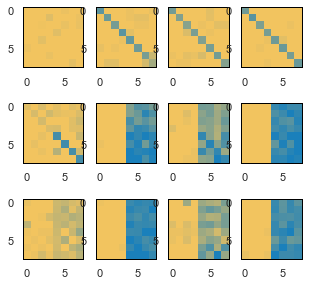

In [35]:
#Behavior only (load behave_dict and plot corct ratios)
df_sessions_f = df_sessions[(df_sessions.index>=0)&(df_sessions.index<40)]

#initialize df with scores per session
df_rats = pd.DataFrame()
#initialize df for analyis_table for all rats and sessions
Big_Analysis_table_mode=pd.DataFrame()

for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict=loaded_data['behave_dict']

        filtered_dict = {k: v for k, v in behave_dict.items() if k != 'Analysis_table_mod'}
        filtered_dict['rats']=session_name[:4]
        filtered_dict['session_name'] = session_name
        filtered_dict['session_title'] = session_title
        filtered_dict['session_id'] = index
        df = pd.DataFrame([filtered_dict])
        if df_rats.empty:
            df_rats = pd.DataFrame(columns=df.columns)
        df_rats = pd.concat([df_rats,df ], axis=0)

        Analysis_table_f = behave_dict['Analysis_table_mod']
        Analysis_table_f['rats'] = session_name[:4]
        Analysis_table_f['session_name'] = session_name
        Analysis_table_f['session_title'] = session_title
        Analysis_table_f['session_id'] = index

        if Big_Analysis_table_mode.empty:
            Big_Analysis_table_mode = pd.DataFrame(columns=Analysis_table_f.columns)
        Big_Analysis_table_mode = pd.concat([Big_Analysis_table_mode,Analysis_table_f], axis=0)
df_rats['bin_column'] = df_rats['session_id'].apply(categorize_into_bins)

#Figure 2a-c
import matplotlib.colors as mcolors

colors = ["#1a80bb", "#f2c45f"]  # Blue to orange shades
num_colors = 100  
blue_to_orange = mcolors.LinearSegmentedColormap.from_list("BlueToOrange", colors, N=num_colors)
fig, axes = plt.subplots(3,4,figsize=(5, 5))

l = [0, 4, 5, 9, 15, 19, 20, 24, 30,34,35,39]
odor_means =Big_Analysis_table_mode.groupby(['session_id','odor_before','odor_ID']).go_nogo.mean()
axes = axes.flatten()

for i, value in enumerate(l):
    go_odors_mat = odor_means.loc[(value, slice(None), slice(None))].unstack().values # select the session #
    axes[i].imshow(go_odors_mat, cmap = blue_to_orange, interpolation='nearest',vmin=0, vmax=1)


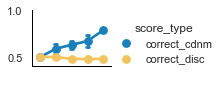

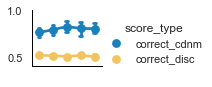

In [36]:
# Learning curves Figure 2d
df_rats['bias']=(df_rats['correct_cdnm']-df_rats['correct_disc'])/(df_rats['correct_disc']+df_rats['correct_cdnm'])
df_reset = df_rats.reset_index(drop=True)


melted_df = pd.melt(df_reset, id_vars=[ 'rats','session_id','bin_column'], value_vars=['correct_cdnm','correct_disc'], var_name='score_type', value_name='score_value')


color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]
df_rats['bias']=(df_rats['correct_cdnm']-df_rats['correct_disc'])/(df_rats['correct_disc']+df_rats['correct_cdnm'])
df_reset = df_rats.reset_index(drop=True)


melted_df = pd.melt(df_reset, id_vars=[ 'rats','session_id','bin_column'], value_vars=['correct_cdnm','correct_disc'], var_name='score_type', value_name='score_value')

color_set = ["#1a80bb", "#f2c45f","#f2c45f","#eddca5"]

for i in range(1, 3):
    data = melted_df[(melted_df.bin_column==i) ]

    g = sns.catplot(data=data, x="session_id", y="score_value", hue="score_type",capsize=.2, palette=color_set,
                    kind="point", height=1.6, aspect=1.45,estimator=np.mean,linestyles=["-", "-"],
                    linewidth=1,  # Line width
                    markers=["o", "o"],  # Marker shapes
                    err_kws={'linewidth': 1.5},  # Width of error bars
                    markersize=2)  # Marker size)
    g.set_titles(""); g.despine(left=False,bottom=False,top=True)
    g.set(ylabel='',xlabel='',xticks = [],title = '',yticks = [.5,1], ylim=(.4, 1))
    plt.show()

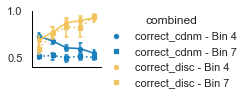

                               sum_sq    df          F        PR(>F)
C(session_id)                0.049723   4.0   5.893966  1.268044e-03
C(bin_column)                0.144942   1.0  68.723701  2.972822e-09
C(session_id):C(bin_column)  0.035195   4.0   4.171956  8.362281e-03
Residual                     0.063271  30.0        NaN           NaN
Post-hoc results for 15:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     4      7  -0.2153 0.001 -0.2756 -0.155   True
--------------------------------------------------
Post-hoc results for 16:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     4      7  -0.1548 0.0016 -0.2244 -0.0853   True
----------------------------------------------------
Post-hoc results for 17:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 

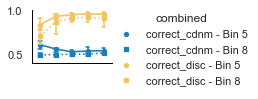

                               sum_sq    df          F    PR(>F)
C(session_id)                0.006541   4.0   1.515011  0.225798
C(bin_column)                0.027945   1.0  25.890370  0.000024
C(session_id):C(bin_column)  0.010971   4.0   2.541200  0.062809
Residual                     0.029142  27.0        NaN       NaN
Post-hoc results for 20:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     5      8  -0.1161 0.0115 -0.1952 -0.0369   True
----------------------------------------------------
Post-hoc results for 21:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     5      8  -0.0631 0.0122 -0.1054 -0.0208   True
----------------------------------------------------
Post-hoc results for 22:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 mean

In [37]:
# Learning curves exp+control combined Figure 2g
df_rats['bias']=(df_rats['correct_cdnm']-df_rats['correct_disc'])/(df_rats['correct_disc']+df_rats['correct_cdnm'])
df_reset = df_rats.reset_index(drop=True)


melted_df = pd.melt(df_reset, id_vars=[ 'rats','session_id','bin_column'], value_vars=['correct_cdnm','correct_disc'], var_name='score_type', value_name='score_value')

color_set = ["#1a80bb", "#1a80bb","#f2c45f","#f2c45f"]

for i in range(4, 6): 
    data = melted_df[((melted_df.bin_column==i) | (melted_df.bin_column==i+3)) ]
    data = data.copy()  
    data['session_id'] = data['session_id'].apply(lambda x: x - 15 if x >= 30 else x)
    data['combined'] = data['score_type'] + ' - Bin ' + data['bin_column'].astype(str)
    
    g = sns.catplot(data=data, x="session_id", y="score_value", hue="combined", dashes = "bin_column",capsize=.2, palette=color_set,
                    kind="point", height=1.6, aspect=1.53,estimator=np.mean,linestyles=["-", ":","-", ":"],
                    linewidth=1,  # Line width
                    markers=["o", "s","o", "s"],  # Marker shapes
                    errwidth=1.5,  # Width of error bars
                    scatter_kws={"s": 10},scale=.6)  # Marker size)
    g.set_titles(""); g.despine(left=False,bottom=False,top=True);
    g.set(ylabel='',xlabel='',xticks = [],title = '',yticks = [.5,1], ylim=(.4, 1))
    plt.show()
    # Performing the two-way ANOVA with interaction
    data_cdnm=data[data['score_type']=='correct_cdnm']
    from statsmodels.formula.api import ols
    
    model = ols('score_value ~ C(session_id) * C(bin_column)', data=data_cdnm).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    print(anova_table)
    
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    
    # Perform pairwise comparisons within each level of factor1
    for level in data_cdnm['session_id'].unique():
        subset = data_cdnm[data_cdnm['session_id'] == level]
    
        tukey = pairwise_tukeyhsd(endog=subset['score_value'], groups=subset['bin_column'], alpha=0.05)
        print(f"Post-hoc results for {level}:")
        print(tukey)                            

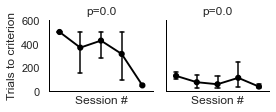

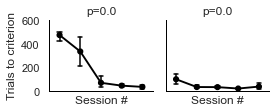

In [38]:
# Trials to criterion. Figure 2 e-h
from scipy.stats import kendalltau

crit_df=pd.DataFrame(columns=['session_id','rats','tr_to_crit'])
index=[]
i=-1
for  (group, df) in Big_Analysis_table_mode.groupby(['session_id','rats'], group_keys=True,sort=False):#to ensure the order of the groups as the original
    i=i+1
    crit_df.loc[i,'session_id']=group[0]
    crit_df.loc[i,'rats']=group[1]
    crit_df.loc[i,'tr_to_crit']=find_first_index(df.reset_index())

crit_df['bin_column'] = crit_df['session_id'].apply(categorize_into_bins)


data = crit_df[(crit_df['session_id']>=0)&(crit_df['session_id']<10) ]

LC = sns.catplot(
    data=data, x="session_id", y="tr_to_crit", col = "bin_column",
    capsize=.2, color='black', errorbar="se",sharex=False,
    kind="point", height=2, aspect=1,scale=0.7, linewidth=1, errwidth=1.5)
LC.despine(left=False,bottom=False,top=True)
#g.refline(y=0.5,linestyle=":")
result = data.groupby(['bin_column','session_id','rats']).agg({'tr_to_crit': 'mean'})

values=result['tr_to_crit']
tau, p_value = kendalltau(values.index, values)
LC.set(ylabel='Trials to criterion',ylim = (0,600), xlabel='Session #',xticks = [],title = f'p={round(p_value,5)}')


plt.show()
LC.savefig("Trials to criterion1.png", dpi=300, bbox_inches='tight')
data = crit_df[(crit_df['session_id']>=15)&(crit_df['session_id']<25) ]

LC = sns.catplot(
    data=data, x="session_id", y="tr_to_crit", col = "bin_column",
    capsize=.2, color='black', errorbar="se",sharex=False,
    kind="point", height=2, aspect=1,scale=0.7, linewidth=1, errwidth=1.5)
LC.despine(left=False,bottom=False,top=True)
#g.refline(y=0.5,linestyle=":")
result = data.groupby(['bin_column','session_id','rats']).agg({'tr_to_crit': 'mean'})

values=result['tr_to_crit']
tau, p_value = kendalltau(values.index, values)
LC.set(ylabel='Trials to criterion',ylim = (0,600), xlabel='Session #',xticks = [],title = f'p={round(p_value,5)}')


plt.show()

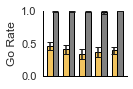

                              sum_sq    df           F        PR(>F)
C(session_id)               0.019507   4.0    0.520465  7.213347e-01
C(Condition)                3.514516   1.0  375.090489  1.655495e-18
C(session_id):C(Condition)  0.017818   4.0    0.475408  7.534197e-01
Residual                    0.281093  30.0         NaN           NaN
Post-hoc results for 5:
            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
       group1              group2       meandiff p-adj lower  upper  reject
---------------------------------------------------------------------------
FaRate_disc0_cdnm0P FaRate_disc0_cdnm1P   0.5211 0.001 0.3685 0.6738   True
---------------------------------------------------------------------------
Post-hoc results for 6:
           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
       group1              group2       meandiff p-adj lower  upper reject
--------------------------------------------------------------------------
Fa

In [39]:
#Go probability figure 2f
from scipy import stats

df_sessions_f = df_sessions[(df_sessions.index>=0)&(df_sessions.index<5)]
df_sessions_f = df_sessions[(df_sessions.index>=5)&(df_sessions.index<10)]
color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]

#initialize df with scores per session
df_behave_bins_temp = []
for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict=loaded_data['behave_dict']


        Analysis_table_f = behave_dict['Analysis_table_mod']
        y = np.array(Analysis_table_f.go_nogo)
        s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
        cdnm_rule = s1[:,0]!=s1[:,1]
        disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])


        MissRate_disc1_cdnm0 =(y[(cdnm_rule==0) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm0P=np.average(MissRate_disc1_cdnm0)
        MissRate_disc1_cdnm1 =(y[(cdnm_rule==1) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm1P=np.average(MissRate_disc1_cdnm1)
        FaRate_disc0_cdnm0 = (y[(cdnm_rule==0) ].astype(bool)==1)
        FaRate_disc0_cdnm0P=np.average(FaRate_disc0_cdnm0)
        FaRate_disc0_cdnm1 = (y[(cdnm_rule==1) ].astype(bool)==1)
        FaRate_disc0_cdnm1P=np.average(FaRate_disc0_cdnm1)
        df_behave_bins_temp.append({'MissRate_disc1_cdnm0P':MissRate_disc1_cdnm0P,
                                    'MissRate_disc1_cdnm1P':MissRate_disc1_cdnm1P,
                                    'FaRate_disc0_cdnm0P':FaRate_disc0_cdnm0P,
                                    'FaRate_disc0_cdnm1P':FaRate_disc0_cdnm1P,
                                    'rats':session_name[:4],
                                    'session_name':session_name,
                                    'session_title':session_title,
                                    'session_id':index})
df_behave_bins=pd.DataFrame(df_behave_bins_temp)

# Group by session_id and calculate mean and SEM
grouped_df = df_behave_bins.groupby('session_id').agg(
    mean_missrate_0=('FaRate_disc0_cdnm0P', 'mean'),
    sem_missrate_0=('FaRate_disc0_cdnm0P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    mean_missrate_1=('FaRate_disc0_cdnm1P', 'mean'),
    sem_missrate_1=('FaRate_disc0_cdnm1P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Plotting the grouped bar chart
x = np.arange(len(grouped_df['session_id']))
width = 0.35

fig, ax = plt.subplots(figsize=(1.5, 1.2))
#fig, ax = plt.subplots(figsize=(5, 5))

bar1 = ax.bar(x - width/2, grouped_df['mean_missrate_0'], width, yerr=grouped_df['sem_missrate_0'], label='MissRate_disc1_cdnm0P', capsize=3,facecolor=color_set[1], edgecolor='black')
bar2 = ax.bar(x + width/2, grouped_df['mean_missrate_1'], width, yerr=grouped_df['sem_missrate_1'], label='MissRate_disc1_cdnm1P', capsize=3,facecolor='gray', edgecolor='black')

ax.set_xlabel('')
ax.set_ylabel('Go Rate')
ax.set_xticks(x)
ax.set_xticklabels('')
#ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines["left"].set_visible(True)  # Ensure left spine is visible

ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.set(ylim=(0,1))
ax.tick_params(axis="y", which="both", length=3, width=1)  # Adjust tick length/width

plt.savefig("GO_cdnma.png", dpi=300, bbox_inches='tight')

plt.show()

# Statistical comparison between MissRate_disc1_cdnm0P and MissRate_disc1_cdnm1P
missrate_0 = df_behave_bins['FaRate_disc0_cdnm0P']
missrate_1 = df_behave_bins['FaRate_disc0_cdnm1P']

# Perform a paired t-test
t_stat, p_val = stats.ttest_rel(missrate_0, missrate_1)

# Prepare data in long format for the ANOVA
anova_data_long = df_behave_bins.melt(id_vars=['rats', 'session_id'], value_vars=['FaRate_disc0_cdnm0P', 'FaRate_disc0_cdnm1P'],
                                      var_name='Condition', value_name='FARate')

# Performing the two-way ANOVA with interaction
model = ols('FARate ~ C(session_id) * C(Condition)', data=anova_data_long).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform pairwise comparisons within each level of factor1
for level in anova_data_long['session_id'].unique():
    subset = anova_data_long[anova_data_long['session_id'] == level]

    tukey = pairwise_tukeyhsd(endog=subset['FARate'], groups=subset['Condition'], alpha=0.05)
    print(f"Post-hoc results for {level}:")
    print(tukey)

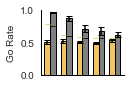

In [12]:
# go prob bars but with control figure 2i
df_sessions_f = df_sessions[(df_sessions.index>=15)&(df_sessions.index<20)]
#df_sessions_f = df_sessions[(df_sessions.index>=20)&(df_sessions.index<25)]

color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]

#initialize df with scores per session
df_behave_bins_temp = []
for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict=loaded_data['behave_dict']


        Analysis_table_f = behave_dict['Analysis_table_mod']
        y = np.array(Analysis_table_f.go_nogo)
        s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
        cdnm_rule = s1[:,0]!=s1[:,1]
        disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])


        MissRate_disc1_cdnm0 =(y[(cdnm_rule==0) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm0P=np.average(MissRate_disc1_cdnm0)
        MissRate_disc1_cdnm1 =(y[(cdnm_rule==1) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm1P=np.average(MissRate_disc1_cdnm1)
        FaRate_disc0_cdnm0 = (y[(cdnm_rule==0) ].astype(bool)==1)
        FaRate_disc0_cdnm0P=np.average(FaRate_disc0_cdnm0)
        FaRate_disc0_cdnm1 = (y[(cdnm_rule==1) ].astype(bool)==1)
        FaRate_disc0_cdnm1P=np.average(FaRate_disc0_cdnm1)
        df_behave_bins_temp.append({'MissRate_disc1_cdnm0P':MissRate_disc1_cdnm0P,
                                    'MissRate_disc1_cdnm1P':MissRate_disc1_cdnm1P,
                                    'FaRate_disc0_cdnm0P':FaRate_disc0_cdnm0P,
                                    'FaRate_disc0_cdnm1P':FaRate_disc0_cdnm1P,
                                    'rats':session_name[:4],
                                    'session_name':session_name,
                                    'session_title':session_title,
                                    'session_id':index})
df_behave_bins=pd.DataFrame(df_behave_bins_temp)

# Group by session_id and calculate mean and SEM
grouped_df = df_behave_bins.groupby('session_id').agg(
    mean_missrate_0=('FaRate_disc0_cdnm0P', 'mean'),
    sem_missrate_0=('FaRate_disc0_cdnm0P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    mean_missrate_1=('FaRate_disc0_cdnm1P', 'mean'),
    sem_missrate_1=('FaRate_disc0_cdnm1P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Plotting the grouped bar chart
x = np.arange(len(grouped_df['session_id']))
width = 0.35

fig, ax = plt.subplots(figsize=(1.5, 1.2))
#fig, ax = plt.subplots(figsize=(5, 5))

bar1 = ax.bar(x - width/2, grouped_df['mean_missrate_0'], width, yerr=grouped_df['sem_missrate_0'], label='MissRate_disc1_cdnm0P', capsize=3,facecolor=color_set[1], edgecolor='black')
bar2 = ax.bar(x + width/2, grouped_df['mean_missrate_1'], width, yerr=grouped_df['sem_missrate_1'], label='MissRate_disc1_cdnm1P', capsize=3,facecolor='gray', edgecolor='black')


df_sessions_f = df_sessions[(df_sessions.index>=35)&(df_sessions.index<40)]
color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]

#initialize df with scores per session
df_behave_bins_temp = []
for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict=loaded_data['behave_dict']


        Analysis_table_f = behave_dict['Analysis_table_mod']
        y = np.array(Analysis_table_f.go_nogo)
        s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
        cdnm_rule = s1[:,0]!=s1[:,1]
        disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])


        MissRate_disc1_cdnm0 =(y[(cdnm_rule==0) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm0P=np.average(MissRate_disc1_cdnm0)
        MissRate_disc1_cdnm1 =(y[(cdnm_rule==1) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm1P=np.average(MissRate_disc1_cdnm1)
        FaRate_disc0_cdnm0 = (y[(cdnm_rule==0) ].astype(bool)==1)
        FaRate_disc0_cdnm0P=np.average(FaRate_disc0_cdnm0)
        FaRate_disc0_cdnm1 = (y[(cdnm_rule==1) ].astype(bool)==1)
        FaRate_disc0_cdnm1P=np.average(FaRate_disc0_cdnm1)
        df_behave_bins_temp.append({'MissRate_disc1_cdnm0P':MissRate_disc1_cdnm0P,
                                    'MissRate_disc1_cdnm1P':MissRate_disc1_cdnm1P,
                                    'FaRate_disc0_cdnm0P':FaRate_disc0_cdnm0P,
                                    'FaRate_disc0_cdnm1P':FaRate_disc0_cdnm1P,
                                    'rats':session_name[:4],
                                    'session_name':session_name,
                                    'session_title':session_title,
                                    'session_id':index})
df_behave_bins=pd.DataFrame(df_behave_bins_temp)

# Group by session_id and calculate mean and SEM
grouped_df = df_behave_bins.groupby('session_id').agg(
    mean_missrate_0=('FaRate_disc0_cdnm0P', 'mean'),
    sem_missrate_0=('FaRate_disc0_cdnm0P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    mean_missrate_1=('FaRate_disc0_cdnm1P', 'mean'),
    sem_missrate_1=('FaRate_disc0_cdnm1P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Plotting the grouped bar chart
x = np.arange(len(grouped_df['session_id']))
width = 0.35

line_width=.8
line_length = 0.16
for X, mean in zip(x - width/2,grouped_df['mean_missrate_0']):
    ax.hlines(y=mean, xmin=X - line_length, xmax=X + line_length, colors=color_set[1], linewidth=line_width,linestyle='-')
for X, mean in zip(x + width/2,grouped_df['mean_missrate_1']):
    ax.hlines(y=mean, xmin=X - line_length, xmax=X + line_length, colors='k', linewidth=line_width,linestyle='-')


ax.set_xlabel('')
ax.set_ylabel('Go Rate')
ax.set_xticks(x)
ax.set_xticklabels('')
#ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines["left"].set_visible(True)  # Ensure left spine is visible

ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.set(ylim=(0,1))
ax.tick_params(axis="y", which="both", length=3, width=1)  # Adjust tick length/width
plt.show()


/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/seaborn/axis

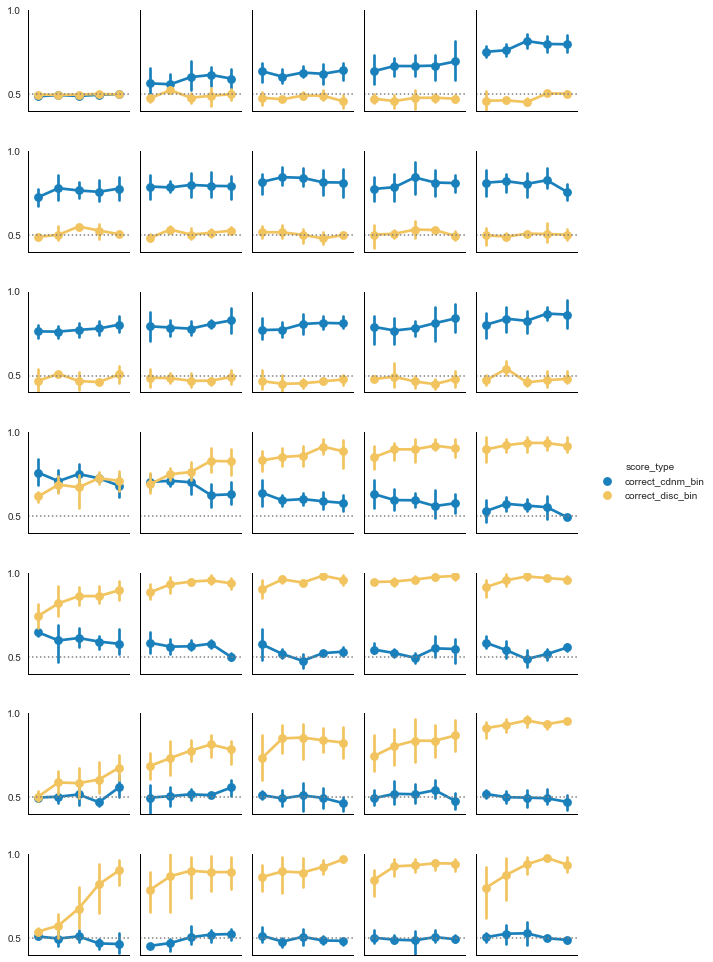

In [13]:
#Learning curves with multiple bins per session Supplementary figure1
df_sessions_f = df_sessions[(df_sessions.index >= 0) & (df_sessions.index < 40) & ~df_sessions.index.isin(range(25, 30))]

#initialize df with scores per session
df_behave_bins_temp = []
bin_num=5
for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict=loaded_data['behave_dict']


        Analysis_table_f = behave_dict['Analysis_table_mod']
        correct_cdnm_bin,correct_disc_bin,dPrime_cdnm_bin,dPrime_disc_bin,HitRate_cdnm_bin,FARate_cdnm_bin,HitRate_disc_bin,FARate_disc_bin,correct_cdnm_only_bin,correct_disc_only_bin = bin_performance(Analysis_table_f,  bin_num=bin_num)
        df_behave_bins_temp.append({'correct_cdnm_bin':correct_cdnm_bin,
                                    'correct_disc_bin':correct_disc_bin,
                                    'dPrime_cdnm_bin':dPrime_cdnm_bin,
                                    'dPrime_disc_bin':dPrime_disc_bin,
                                    'HitRate_cdnm_bin':HitRate_cdnm_bin,
                                    'FARate_cdnm_bin':FARate_cdnm_bin,
                                    'HitRate_disc_bin':HitRate_disc_bin,
                                    'FARate_disc_bin':FARate_disc_bin,
                                    'correct_cdnm_only_bin':correct_cdnm_only_bin,
                                    'correct_disc_only_bin':correct_disc_only_bin,
                                    'bin_id':range(bin_num),
                                    'rats':session_name[:4],
                                    'session_name':session_name,
                                    'session_title':session_title,
                                    'session_id':index})
df_behave_bins=pd.DataFrame(df_behave_bins_temp)
df_behave_bins
df_behave_bins_exploded = df_behave_bins.explode(['correct_cdnm_bin','correct_disc_bin','dPrime_cdnm_bin','dPrime_disc_bin','HitRate_cdnm_bin','FARate_cdnm_bin',
                                                  'HitRate_disc_bin','FARate_disc_bin','correct_cdnm_only_bin','correct_disc_only_bin','bin_id'])
df_behave_bins_exploded
data = pd.melt(df_behave_bins_exploded, id_vars=[ 'rats','session_id','bin_id'], value_vars=['correct_cdnm_bin','correct_disc_bin'], var_name='score_type', value_name='score_value')

color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]
LC = sns.catplot(data=data, x="bin_id", y="score_value", palette=color_set,
                 errorbar="se",sharex=False,col = "session_id",hue='score_type',col_wrap=5,
                 kind="point", height=2, aspect=.85)
LC.despine(left=False,bottom=False,top=True)
LC.refline(y=.5,linestyle=":")
LC.set(ylim=(.4,1),ylabel='',xlabel='',xticks = [],yticks=[.5, 1],title = '')

plt.show()

[Text(0, 0, ''),
 Text(5, 0, ''),
 Text(10, 0, ''),
 Text(15, 0, ''),
 Text(20, 0, '')]

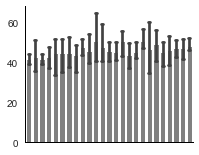

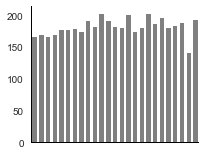

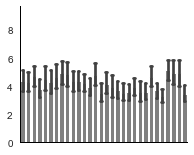

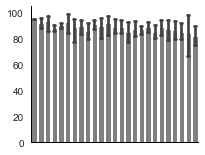

In [14]:
# Suplementary figure 2
Responsiveness = pd.DataFrame(columns=['session_name','session_title','cell_num','FR','FR_spont'])

for index, row in df_sessions.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        # Analysis_table_f = loaded_data['Analysis_table_f']  
        # spikeTime = loaded_data['spikeTime']
        # PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime,events = ['odor_unpoke'] , resp_win = (-.5, 0)) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
        # spikes_all = np.squeeze(spikes_all)
        # cell_num = spikes_all.shape[1]
        #        FR = np.mean(np.mean(spikes_all,axis=2),0)
        FR = loaded_data['responsivness']['FR_all']

        FR_spont = loaded_data['responsivness']['FR_spont']
        cell_num = len(FR_spont)
        new_row = pd.DataFrame([{
            'session_name': session_name,
            'session_title': session_title,
            'cell_num': cell_num,
            'FR': [FR],  # No need for brackets around single values
            'FR_spont': [FR_spont]  # No need for brackets around single values
        }])
        Responsiveness = pd.concat([Responsiveness, new_row], ignore_index=True)
        # Responsiveness = Responsiveness.append({'session_name':session_name,'session_title':session_title,'cell_num':cell_num,'FR':[FR],'FR_spont': [FR_spont]}, ignore_index=True)
fig, ax = plt.subplots(figsize=(3, 2.5))

#sns.barplot(data=Responsiveness,x='session_title',y='cell_num',ax=ax,color='black',)
#sns.boxplot(data=Responsiveness,x='session_title',y='cell_num',ax=ax,color='gray',showcaps=False, whiskerprops={'visible': False}, showfliers=False,width=.6)
sns.barplot(data=Responsiveness,x='session_title',y='cell_num',ax=ax,color='gray', capsize=.3, alpha=1)

plt.xlim([-.5,24.5])
#plt.ylim([30,60])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('')
ax.set_xlabel('')


ax.set_xticks([0,5,10,15,20])  # Set only one x-tick at zero
ax.set_xticklabels('')  # Set only one x-tick at zero

results = Responsiveness.groupby('session_title',sort=False).agg(
    Sum=('cell_num', 'sum'),
    StdDev=('cell_num', 'std')
).reset_index()
results.Sum[0:29].mean()
results.Sum[0:29].std()
fig, ax = plt.subplots(figsize=(3, 2.5))

#sns.barplot(x=np.arange(40), y=results.Sum,color='k',ax=ax)
sns.barplot(data=results,x='session_title',y='Sum',ax=ax,color='gray', capsize=.5, alpha=1)

plt.xlim([-.5,24.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('')
ax.set_xlabel('')


ax.set_xticks([0,5,10,15,20])  # Set only one x-tick at zero
ax.set_xticklabels('')  # Set only one x-tick at zero
Responsiveness_FR = Responsiveness.explode('FR').explode('FR')# Explode the lists to create separate rows for each value
fig, ax = plt.subplots(figsize=(3, 2.5))
#sns.boxplot(data=Responsiveness_FR,x='session_title',y='FR',ax=ax,color='gray',showcaps=False, whiskerprops={'visible': False}, showfliers=False,width=.6)
sns.barplot(data=Responsiveness_FR,x='session_title',y='FR',ax=ax,color='gray', capsize=.3, alpha=1)
ax.set_xlabel('')
plt.xlim([-.5,29.5])
ax.set_xticks([0,5,10,15,20])  # Set only one x-tick at zero
ax.set_xticklabels('')  # Set only one x-tick at zeroplt.ylim([0,10])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('')
df = pd.DataFrame()

for index, row in df_sessions.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']

    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        result_dict_Zeta = loaded_data['result_dict_Zeta']
        for i in range(len(result_dict_Zeta['p_responsive'])):
            # df = df.append({'session_name': session_name, 'session_title': session_title, 'p_responsive': result_dict_Zeta['p_responsive'][i], 'p_cdnm': result_dict_Zeta['p_cdnm'][i], 'p_disc': result_dict_Zeta['p_disc'][i]}, ignore_index=True)
            new_row = pd.DataFrame([{
                'session_name': session_name,
                'session_title': session_title,
                'p_responsive': result_dict_Zeta['p_responsive'][i],
                'p_cdnm': result_dict_Zeta['p_cdnm'][i],
                'p_disc': result_dict_Zeta['p_disc'][i]
            }])
            df = pd.concat([df, new_row], ignore_index=True)


df['responsive'] = (df['p_responsive'] < 0.01)

original_order = df['session_title'].unique()
result_cdnm = df.groupby(['session_title','session_name'])['responsive'].mean() #mean for each rat in session
result_cdnm_sorted = result_cdnm.loc[original_order]* 100
result_cdnm_sorted_i=result_cdnm_sorted.reset_index()
fig, ax = plt.subplots(figsize=(3, 2.5))
sns.barplot(data=result_cdnm_sorted_i,x='session_title',y='responsive',ax=ax,color='gray', capsize=.3, alpha=1)
plt.xlim([-.5,24.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('')
ax.set_xticks([0,5,10,15,20])  # Set only one x-tick at zero
ax.set_xlabel('')

ax.set_xticklabels('')  # Set only one x-tick at zeroplt.ylim([0,10])

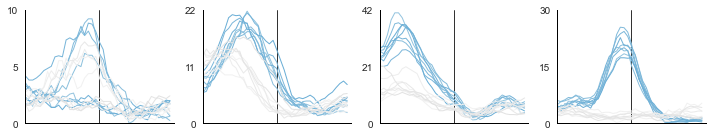

In [15]:
#Figure 3a
fig, axes = plt.subplots(1,4,figsize=(10, 2))
axes = axes.flatten()
shades_of_blue1 = plt.cm.Blues(np.linspace(.4, .5, 8))  # Avoid very light blues
shades_of_blue2 = plt.cm.Greys(np.linspace(.1, .2, 8))  # Avoid very light blues
colors = np.vstack((shades_of_blue1,shades_of_blue2)) #to plot only non-match contingencies

window_size = 5
h=np.ones(window_size)/window_size
sessions=['cd11_1031_cdnma','cd11_1114_cdnma','cd10_1125_cdnmb','cd11_1121_cdnmb']
cell=[28,16,12,13]
ylims=[10,22,42,30]

for cc in range(0, 4):
    session_name=sessions[cc]
    i=cell[cc]
    y_lim=ylims[cc]
    with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
        loaded_data = pickle.load(f)
    spikeTime = loaded_data["spikeTime"]
    Analysis_table_f = loaded_data["Analysis_table_f"]
    PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime , events = ['odor_unpoke'] , resp_win = (-1, 1),binduration=.05) #Trials by 
    u_vals = np.sort(pd.unique(Trials["vals_and_ID"]))
    axes[cc].plot([20, 20], [0, y_lim], 'k-', linewidth=.8)    
    for val_id, val in enumerate(u_vals):
        inds1 = Trials["vals_and_ID"]==val
    
        x=np.mean(spikes_all[0,inds1,i,:],0)
        x_padded_reflect = np.pad(x, (len(h)//2, len(h)//2), mode='reflect')
        y_smoothed1 = np.convolve(x_padded_reflect, h, mode='same')
        axes[cc].plot(y_smoothed1[2:-2],color=colors[val_id,:],linewidth=1) # without the padding and normalize to Hz
    axes[cc].set_xlim(0, 40)
    axes[cc].set_ylim(0, y_lim)
    
    specific_ticks = [0, 20, 40]
    specific_labels = ['-1', '0', '1']

    axes[cc].set_xticks(specific_ticks)
    axes[cc].set_xticklabels(specific_labels,fontsize=8)
    axes[cc].set_yticks([0, y_lim/2, y_lim])

    axes[cc].yaxis.set_visible(True)
    axes[cc].xaxis.set_visible(False)
    
    axes[cc].spines['top'].set_visible(False)
    axes[cc].spines['right'].set_visible(False)
    axes[cc].spines['bottom'].set_visible(True)
    axes[cc].spines['left'].set_visible(True)
plt.tight_layout()
plt.show()

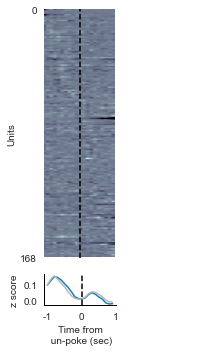

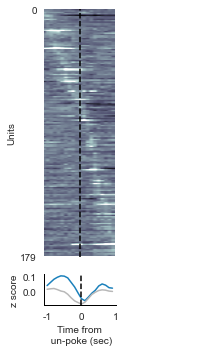

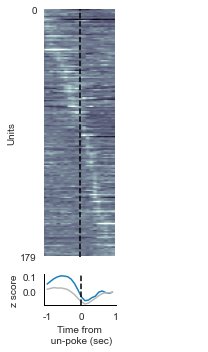

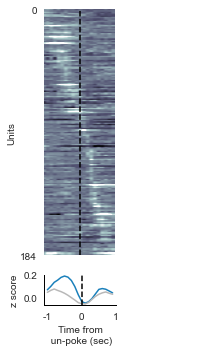

In [16]:
#figure 3b
for i in [0,4,5,9]:
    df_sessions_f=df_sessions.loc[i]
    session_title = df_sessions_f['session_title']
    session_names = df_sessions_f['session_names']
    Z_score_cdnm_go=[]
    Z_score_cdnm_nogo=[]
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        Analysis_table_f=loaded_data['Analysis_table_f']
        spikeTime = loaded_data['spikeTime']
        PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime , events = ['odor_unpoke'] , resp_win = (-1,1),binduration=.1)
        nbins = spikes_all.shape[-1]  
        responsiveness = loaded_data['responsivness']
        p_responsive = loaded_data['result_dict_Zeta']['p_responsive']
        resp_units = p_responsive<0.001
        baseline_mean = responsiveness.FR_spont
        baseline_std = responsiveness.FR_spont_std
        baseline_std[baseline_std==0] = 1
        temp = baseline_mean.to_numpy()[:, np.newaxis]  
        replicated_baseline_mean = np.tile(temp, (1, nbins))
        temp = baseline_std.to_numpy()[:, np.newaxis]
        replicated_baseline_std = np.tile(temp, (1, nbins))
        spikes_all=np.squeeze(spikes_all)
        trials_idx = Trials.cdnm_rule == True
        mean_fr = np.mean(np.squeeze(spikes_all[trials_idx,:,:]),0)
        z_score_cdnm_go = (mean_fr - replicated_baseline_mean)/replicated_baseline_std    
        Z_score_cdnm_go.append(z_score_cdnm_go)    
        trials_idx = Trials.cdnm_rule == False    
        mean_fr = np.mean(np.squeeze(spikes_all[trials_idx,:,:]),0)
        z_score_cdnm_nogo = (mean_fr - replicated_baseline_mean)/replicated_baseline_std   
        Z_score_cdnm_nogo.append(z_score_cdnm_nogo)
    fig1=plot_zscore(Z_score_cdnm_go ,Z_score_cdnm_nogo ,color_go = color_set[0])


/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15358/1579823598.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_zeta_by_session=df_zeta.groupby(['session_id','session_name']).agg('mean')
/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15358/1579823598.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{abs(int(label))}" for label in ax.get_yticks()])


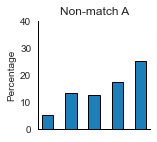

/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15358/1579823598.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{abs(int(label))}" for label in ax.get_yticks()])


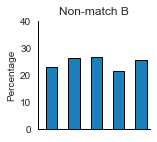

/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15358/1579823598.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{abs(int(label))}" for label in ax.get_yticks()])


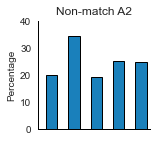

In [17]:
#Figure 3c-
df_zeta = pd.DataFrame()

for index, row in df_sessions.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']

    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        result_dict_Zeta = loaded_data['result_dict_Zeta']
        for i in range(len(result_dict_Zeta['p_responsive'])):


            new_row = pd.DataFrame([{
                'session_name': session_name,
                'session_title': session_title,
                'session_id': index,
                'p_responsive': result_dict_Zeta['p_responsive'][i],
                'p_cdnm': result_dict_Zeta['p_cdnm'][i],
                'p_disc': result_dict_Zeta['p_disc'][i]
            }])            
            df_zeta = pd.concat([df_zeta, new_row], ignore_index=True)

            # df_zeta = df_zeta.append({'session_name': session_name, 'session_title': session_title,'session_id': index, 'p_responsive': result_dict_Zeta['p_responsive'][i], 'p_cdnm': result_dict_Zeta['p_cdnm'][i], 'p_disc': result_dict_Zeta['p_disc'][i]}, ignore_index=True)

from matplotlib.colors import to_hex

df_zeta['both_conditions_cdnm'] = (df_zeta['p_responsive'] < 0.01) & (df_zeta['p_cdnm'] < 0.01)
df_zeta['both_conditions_disc'] = (df_zeta['p_responsive'] < 0.01) & (df_zeta['p_disc'] < 0.01)
df_zeta['three_conditions'] = (df_zeta['p_responsive'] < 0.01) & (df_zeta['p_disc'] < 0.01) & (df_zeta['p_cdnm'] < 0.01)
original_order = df_zeta['session_title'].unique()

result_cdnm = df_zeta.groupby('session_title')['both_conditions_cdnm'].mean()
result_disc = df_zeta.groupby('session_title')['both_conditions_disc'].mean()
result_both = df_zeta.groupby('session_title')['three_conditions'].mean()

result_cdnm_sorted = result_cdnm.loc[original_order]* 100
result_disc_sorted = result_disc.loc[original_order]* -100
result_both_sorted = result_both.loc[original_order]* 100
bottoms = result_both_sorted.to_numpy()/-2

color_cdnm = sns.color_palette('Set1')[0]
color_disc= sns.color_palette('Set1')[1]
mixture_color = sns.color_palette()[4]

color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]
color_cdnm=color_set[0]
color_disc=color_set[1]
mixture_color=color_set[2]
df_zeta_by_session=df_zeta.groupby(['session_id','session_name']).agg('mean')

fig, ax = plt.subplots(figsize=(2, 2))  
result_cdnm_sorted.plot(kind='bar', color=color_cdnm, edgecolor='black',ax = ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_ylim(0,40)
plt.title('Non-match A')
plt.xlabel('')
plt.ylabel('Percentage')
ax.set_yticklabels([f"{abs(int(label))}" for label in ax.get_yticks()])
ax.set_xlim(-.4,4.4)
plt.xticks(ticks=[])  
plt.show()

fig, ax = plt.subplots(figsize=(2, 2))  
result_cdnm_sorted.plot(kind='bar', color=color_cdnm, edgecolor='black',ax = ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_ylim(0,40)
plt.title('Non-match B')
plt.xlabel('')
plt.ylabel('Percentage')
ax.set_yticklabels([f"{abs(int(label))}" for label in ax.get_yticks()])
ax.set_xlim(4.4,9.4)
plt.xticks(ticks=[])  
plt.show()

fig, ax = plt.subplots(figsize=(2, 2))  
result_cdnm_sorted.plot(kind='bar', color=color_cdnm, edgecolor='black',ax = ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_ylim(0,40)
plt.title('Non-match A2')
plt.xlabel('')
plt.ylabel('Percentage')
ax.set_yticklabels([f"{abs(int(label))}" for label in ax.get_yticks()])
ax.set_xlim(9.4,14.4)
plt.xticks(ticks=[])  
plt.show()

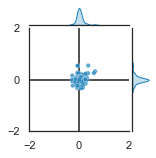

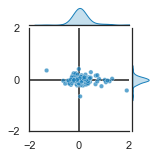

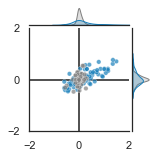

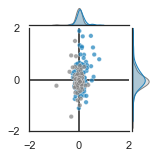

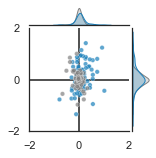

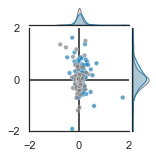

In [18]:
#Figure 4a,c
from scipy.stats import ks_2samp

sns.set(style="white")  # Set the style for the plot
color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]

Responsiveness_all = pd.DataFrame()
for index, row in df_sessions.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    Responsiveness = pd.DataFrame()

    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        responsiveness = loaded_data['responsivness']
        if Responsiveness.empty:
            Responsiveness = pd.DataFrame(columns=responsiveness.columns)
        responsiveness['session_name'] = session_name
        responsiveness['session_title'] = session_title
        responsiveness['session_title_idx'] = index
        responsiveness['p_responsive'] = loaded_data['result_dict_Zeta']['p_responsive']
        responsiveness['z_cdnm_go']=(responsiveness.FR_cdnm_go-responsiveness.FR_spont)/responsiveness.FR_spont_std
        responsiveness['z_cdnm_nogo']=(responsiveness.FR_cdnm_nogo-responsiveness.FR_spont)/responsiveness.FR_spont_std
        responsiveness['z_disc_go']=(responsiveness.FR_disc_go-responsiveness.FR_spont)/responsiveness.FR_spont_std
        responsiveness['z_disc_nogo']=(responsiveness.FR_disc_nogo-responsiveness.FR_spont)/responsiveness.FR_spont_std

        Responsiveness = pd.concat([Responsiveness, responsiveness], ignore_index=True)

    if Responsiveness_all.empty:
        Responsiveness_all = pd.DataFrame(columns=Responsiveness.columns)
    #Responsiveness_all = Responsiveness_all.append(Responsiveness, ignore_index=True)
    Responsiveness_all = pd.concat([Responsiveness_all, Responsiveness], ignore_index=True)
color_set = ["#1a80bb"]
for i in [0,4]:
    
    
    Responsiveness_all_temp = Responsiveness_all[(Responsiveness_all['p_responsive']<0.001) & (Responsiveness_all.session_title_idx==i) ]
    Responsiveness_all_temp = Responsiveness_all_temp.copy()  # Ensure a new DataFrame copy
    Responsiveness_all_temp.loc[:, 'data1'] = (Responsiveness_all_temp['z_cdnm_go'] - Responsiveness_all_temp['z_cdnm_nogo'])
    Responsiveness_all_temp = Responsiveness_all_temp.copy()  # Ensure a new DataFrame copy
    Responsiveness_all_temp.loc[:, 'data2'] = (Responsiveness_all_temp['z_disc_go'] - Responsiveness_all_temp['z_disc_nogo'])
    g = sns.jointplot(data=Responsiveness_all_temp,
                      x='data1',
                      y='data2',
                      hue = 'session_title_idx',
                      palette=color_set,
                      marginal_kws=dict(common_norm=False),  # Normalize the KDEs separately for each hue level
                      xlim=(-2,2),ylim=(-2,2),
                      kind="scatter", s=20,alpha=.7,zorder=2
                      )
        
    main_ax = g.ax_joint
    main_ax.plot([-2,2],[0,0],'k',alpha = 1,zorder=1)
    main_ax.plot([0,0],[-2,2],'k',alpha = 1,zorder=1)
    g.ax_joint.set_xticks([-2, 0, 2])
    g.ax_joint.set_yticks([-2, 0, 2])    
    g.set_axis_labels("", "")
    marg_x_ax = g.ax_marg_x  # X-axis marginal axis
    main_ax.legend_.remove()
    fig = g.fig
    fig.set_size_inches(2, 2)  # Width, height in inches

color_set = ["#1a80bb", 'grey']
for i in [15,19,20,24]:

    Responsiveness_all_temp = Responsiveness_all[(Responsiveness_all['p_responsive']<0.001) & ((Responsiveness_all.session_title_idx==i) | (Responsiveness_all.session_title_idx==i+15)) ]
    Responsiveness_all_temp = Responsiveness_all_temp.copy()  # Ensure a new DataFrame copy
    Responsiveness_all_temp.loc[:, 'data1'] = (Responsiveness_all_temp['z_cdnm_go'] - Responsiveness_all_temp['z_cdnm_nogo'])
    Responsiveness_all_temp = Responsiveness_all_temp.copy()  # Ensure a new DataFrame copy
    Responsiveness_all_temp.loc[:, 'data2'] = (Responsiveness_all_temp['z_disc_go'] - Responsiveness_all_temp['z_disc_nogo'])
    Responsiveness_all_temp2 = Responsiveness_all_temp.copy()
    Responsiveness_all_temp2.loc[Responsiveness_all_temp2['data1'] > 2, 'data1'] = np.nan
    Responsiveness_all_temp2.loc[Responsiveness_all_temp2['data2'] > 2, 'data2'] = np.nan
    
    g = sns.jointplot(data=Responsiveness_all_temp2,
                      x='data1',
                      y='data2',
                      hue = 'session_title_idx',
                      palette=color_set,  # Use a predefined palette, or you can use custom colors like ['#FF6347', '#4682B4']
                      marginal_kws=dict(common_norm=False),  # Normalize the KDEs separately for each hue level
                      xlim=(-2,2),ylim=(-2,2),
                      kind="scatter", zorder=2, s=20,alpha=.7
                      )
    main_ax = g.ax_joint
    main_ax.plot([-2,2],[0,0],'k',alpha = 1,zorder=1)
    main_ax.plot([0,0],[-2,2],'k',alpha = 1,zorder=1)
    marg_x_ax = g.ax_marg_x  # X-axis marginal axis
    
    group_A = Responsiveness_all_temp[Responsiveness_all_temp['session_title_idx'] == i]['data1']
    group_B = Responsiveness_all_temp[Responsiveness_all_temp['session_title_idx'] == i+15]['data1']
    ks_statistic, p_value_cdnm = ks_2samp(group_A, group_B)# Run the Kolmogorov-Smirnov test
    
    group_A = Responsiveness_all_temp[Responsiveness_all_temp['session_title_idx'] == i]['data2']
    group_B = Responsiveness_all_temp[Responsiveness_all_temp['session_title_idx'] == i+15]['data2']
    ks_statistic, p_value_disc = ks_2samp(group_A, group_B)# Run the Kolmogorov-Smirnov test
     
    main_ax.legend_.remove()
    g.ax_joint.set_xticks([-2, 0, 2])
    g.ax_joint.set_yticks([-2, 0, 2])    
    g.set_axis_labels("", "")
    fig = g.fig    
    fig.set_size_inches(2, 2)  # Width, height in inches
    
    group_A = Responsiveness_all_temp[Responsiveness_all_temp['session_title_idx'] == i]['z_cdnm_nogo']
    group_B = Responsiveness_all_temp[Responsiveness_all_temp['session_title_idx'] == i+15]['z_disc_nogo']
    t_statistic, ttest_p_value = ttest_ind(group_A, group_B, equal_var=False)  # Set equal_var=False for Welch's t-test
    
 

/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15358/2484495893.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{abs(int(label))}" for label in ax.get_yticks()])


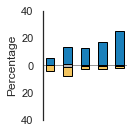

In [19]:
# #figure 4b
fig, ax = plt.subplots(figsize=(1.5, 2))  # Adjust the width and height as needed
ax.axhline(0, color='gray', linewidth=0.8, linestyle='-',zorder=1)  # Zero line for context (not inside bars)

result_cdnm_sorted.plot(kind='bar', color=color_cdnm, edgecolor='black',ax = ax,zorder=2)
result_disc_sorted.plot(kind='bar', color=color_disc, edgecolor='black',zorder=2)
result_both_sorted.plot(kind='bar', color=mixture_color, edgecolor='black',bottom = bottoms,zorder=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylim(-40,40)
plt.title('')
plt.xlabel('')
plt.ylabel('Percentage')
ax.set_yticklabels([f"{abs(int(label))}" for label in ax.get_yticks()])
plt.xticks(ticks=[])
ax.set_xlim(-.4,4.4)
plt.show()

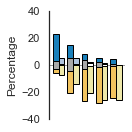

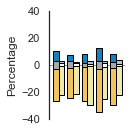

In [20]:
#figure 4d
e_cdnm=result_cdnm_sorted.iloc[15:20].values
e_disc=result_disc_sorted.iloc[15:20].values
e_both=result_both_sorted.iloc[15:20].values

c_cdnm=result_cdnm_sorted.iloc[30:35].values
c_disc=result_disc_sorted.iloc[30:35].values
c_both=result_both_sorted.iloc[30:35].values

x1=[1,3,5,7,9]
x2=[2,4,6,8,10]

df=pd.DataFrame({'x1':x1,'x2':x2,'e_cdnm':e_cdnm,'e_disc':e_disc,'e_both':e_both,'c_cdnm':c_cdnm,'c_disc':c_disc,'c_both':c_both})
group1 = df[['e_cdnm', 'e_disc', 'e_both']]
group2 = df[['c_cdnm', 'c_disc', 'c_both']]
group1.columns = ['cdnm', 'disc', 'both']
group2.columns = ['cdnm', 'disc', 'both']
concatenated_df = pd.concat([group1, group2], ignore_index=False)
concatenated_df['Group'] = ['exp'] * len(group1) + ['control'] * len(group2)
concatenated_df['Index']=concatenated_df.index
data=concatenated_df
exp_data = data[data['Group'] == 'exp']
control_data = data[data['Group'] == 'control']
bar_width = 0.4
index = np.arange(len(exp_data))  # Positions for groups

fig, ax = plt.subplots(figsize=(2, 2))  # Adjust the width and height as needed
ax.axhline(0, color='gray', linewidth=0.8, linestyle='-',zorder=1)  # Zero line for context (not inside bars)
ax.bar(index - bar_width / 2, exp_data['cdnm'], bar_width, color='#1a80bb', label='cdnm (exp)', edgecolor='black',zorder=2)
ax.bar(index - bar_width / 2, exp_data['disc'], bar_width, color='#f2c45f', label='disc (exp)', edgecolor='black',zorder=2)

ax.bar(index - bar_width / 2, exp_data['both'], bar_width, bottom=-exp_data['both'] / 2,
       color='darkgray', label='both (exp)', edgecolor='black', alpha=1,zorder=2)

ax.bar(index + bar_width / 2, control_data['cdnm'], bar_width, color='lightsteelblue', label='cdnm (control)', edgecolor='black',zorder=2)
ax.bar(index + bar_width / 2, control_data['disc'], bar_width, color='palegoldenrod', label='disc (control)', edgecolor='black',zorder=2)

ax.bar(index + bar_width / 2, control_data['both'], bar_width, bottom=-control_data['both'] / 2,
       color='white', label='both (control)', edgecolor='black', alpha=1,zorder=2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylim(-40,40)
plt.title('')
plt.xlabel('')
plt.ylabel('Percentage')
plt.xticks(ticks=[])

ax.grid(False)
plt.tight_layout()
plt.show()
e_cdnm=result_cdnm_sorted.iloc[20:25].values
e_disc=result_disc_sorted.iloc[20:25].values
e_both=result_both_sorted.iloc[20:25].values

c_cdnm=result_cdnm_sorted.iloc[35:40].values
c_disc=result_disc_sorted.iloc[35:40].values
c_both=result_both_sorted.iloc[35:40].values

x1=[1,3,5,7,9]
x2=[2,4,6,8,10]

df=pd.DataFrame({'x1':x1,'x2':x2,'e_cdnm':e_cdnm,'e_disc':e_disc,'e_both':e_both,'c_cdnm':c_cdnm,'c_disc':c_disc,'c_both':c_both})
group1 = df[['e_cdnm', 'e_disc', 'e_both']]
group2 = df[['c_cdnm', 'c_disc', 'c_both']]
group1.columns = ['cdnm', 'disc', 'both']
group2.columns = ['cdnm', 'disc', 'both']
concatenated_df = pd.concat([group1, group2], ignore_index=False)
concatenated_df['Group'] = ['exp'] * len(group1) + ['control'] * len(group2)
concatenated_df['Index']=concatenated_df.index
data=concatenated_df
exp_data = data[data['Group'] == 'exp']
control_data = data[data['Group'] == 'control']
bar_width = 0.4
index = np.arange(len(exp_data))  # Positions for groups
fig, ax = plt.subplots(figsize=(2, 2))  # Adjust the width and height as needed
ax.axhline(0, color='gray', linewidth=0.8, linestyle='-',zorder=1)  # Zero line for context (not inside bars)
ax.bar(index - bar_width / 2, exp_data['cdnm'], bar_width, color='#1a80bb', label='cdnm (exp)', edgecolor='black',zorder=2)
ax.bar(index - bar_width / 2, exp_data['disc'], bar_width, color='#f2c45f', label='disc (exp)', edgecolor='black',zorder=2)
ax.bar(index - bar_width / 2, exp_data['both'], bar_width, bottom=-exp_data['both'] / 2,
       color='darkgray', label='both (exp)', edgecolor='black', alpha=1,zorder=2)
ax.bar(index + bar_width / 2, control_data['cdnm'], bar_width, color='lightsteelblue', label='cdnm (control)', edgecolor='black',zorder=2)
ax.bar(index + bar_width / 2, control_data['disc'], bar_width, color='palegoldenrod', label='disc (control)', edgecolor='black',zorder=2)
ax.bar(index + bar_width / 2, control_data['both'], bar_width, bottom=-control_data['both'] / 2,
       color='white', label='both (control)', edgecolor='black', alpha=1,zorder=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylim(-40,40)
plt.title('')
plt.xlabel('')
plt.ylabel('Percentage')
plt.xticks(ticks=[])
ax.grid(False)
plt.tight_layout()
plt.show()

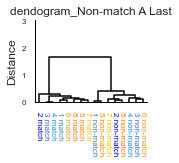

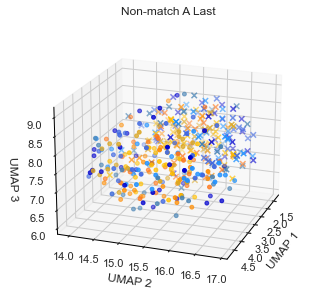

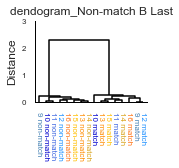

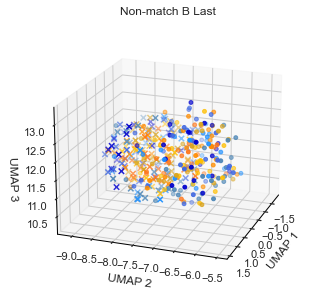

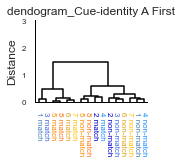

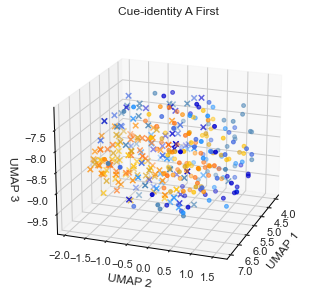

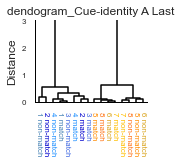

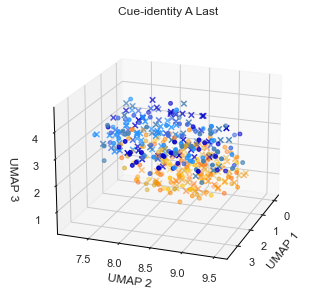

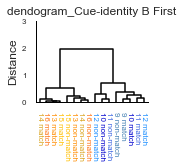

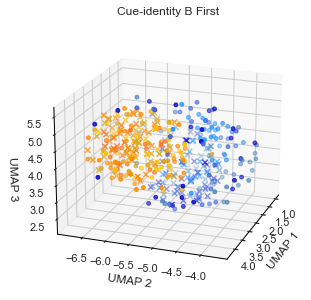

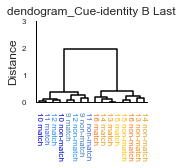

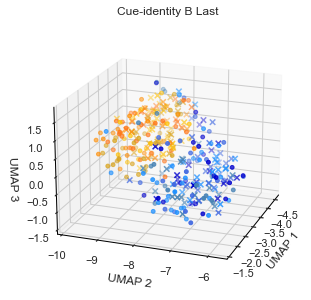

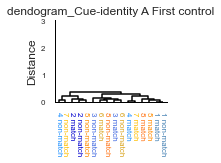

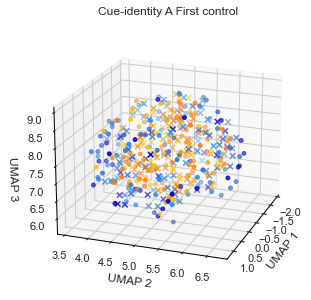

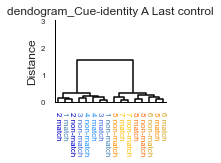

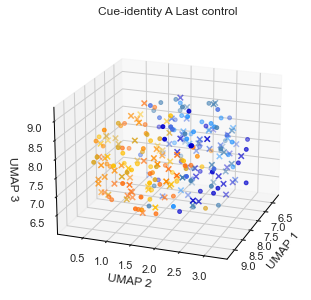

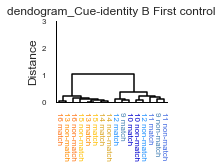

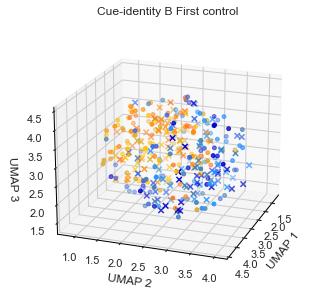

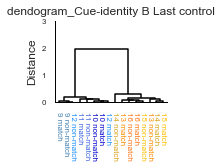

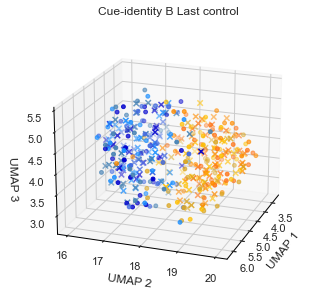

In [40]:
#fig 5 a-c
for i in [4,9,15,19,20,24,30,34,35,39]:
    df_sessions_f=df_sessions.loc[i]
    session_title = df_sessions_f['session_title']
    
    with open(f'{save_path}/UMAP_{session_title}.pkl', 'rb') as f:
        loaded_data = pickle.load(f)
    linkage_matrix= loaded_data['linkage_matrix']
    cluster_means= loaded_data['cluster_means']
    
    fig1, ax1 = plot_dendrogram(linkage_matrix,cluster_means,session_title,figsize=(2, 1.5))
    #plt.ylim(0, 4)  # Adjust the range as needed    
    Trials=loaded_data['Trials']
    y=Trials.vals_and_ID.rank(method='dense', ascending=True).astype(int) - 1
    X_umap = loaded_data['X_umap']
    fig2, ax2 = plot_3d(X_umap, y,session_title,figsize=(5,5))
    ax2.view_init( elev=20,azim=20)  # Elevation and azimuth

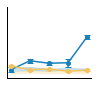

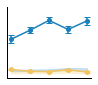

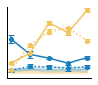

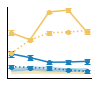

In [41]:
# Figure 5d-e
data_list=[]
df_temp=[]
range1 = list(range(0, 25))  # 0 to 25
range2 = list(range(30, 40))  # 30 to 39
combined_list = range1 + range2
for i in combined_list :
    df_sessions_f=df_sessions.loc[i]
    session_title = df_sessions_f['session_title']
    with open(f'{save_path}/UMAP_{session_title}.pkl', 'rb') as f:
        loaded_data = pickle.load(f)
    cluster_means=loaded_data['cluster_means']
    cluster_std=loaded_data['cluster_std']
    loaded_data['session_id'] =i
    loaded_data['mean_perm'] =np.mean(loaded_data['perm_mean_1_8'])
    loaded_data['std_perm'] =np.std(loaded_data['perm_mean_1_8'])
    loaded_data['mean_perm_cueid'] =np.mean(loaded_data['perm_mean_cue_id'])
    loaded_data['std_perm_cueid'] =np.std(loaded_data['perm_mean_cue_id'])
    data_list.append(loaded_data)
    df = pd.DataFrame(data_list)
    
color_set = ["#1a80bb", "#f2c45f"]
line_styles=['-',':']
df['bin_column'] = df['session_id'].apply(categorize_into_bins)

for l in [1,2]:
    group = df[(df.bin_column==l)]
    plt.figure(figsize=(1.5, 1.3))
    
    color = color_set[0]  # Default to gray if the bin is not in the dictionary
    plt.errorbar(
        group['session_id'],         # X-axis
        group['mean_1_8'],           # Y-axis        
        yerr=group['sem_1_8'],
        capsize=3,    
        marker='o',                  # Marker style
        markersize=4,                  # Marker style
        linestyle='-',               # Line style
        color=color,
    )
    color = color_set[1]  # Default to gray if the bin is not in the dictionary
    plt.errorbar(
        group['session_id'],         # X-axis
        group['mean_cue_id'],           # Y-axis        
        yerr=group['sem_cue_id'],
        capsize=3,
        marker='o',                  # Marker style
        markersize=4,                  # Marker style
        linestyle='-',               # Line style
        color=color,
    )
    color = color_set[0]  # Default to gray if the bin is not in the dictionary
    
    plt.fill_between(
        group['session_id'],
        group['mean_perm'] - group['std_perm'],  # Lower bound
        group['mean_perm'] + group['std_perm'],  # Upper bound
        color=color,
        alpha=0.2  # Transparency level for shading
    )
    color = color_set[1]  # Default to gray if the bin is not in the dictionary
    plt.fill_between(
        group['session_id'],
        group['mean_perm_cueid'] - group['std_perm_cueid'],  # Lower bound
        group['mean_perm_cueid'] + group['std_perm_cueid'],  # Upper bound
        color=color,
        alpha=0.2  # Transparency level for shading
    )
    ax = plt.gca()
    plt.xticks([])
    plt.yticks([])
    plt.ylim([0,3])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for l in [4,5]:    
    data = df[((df.bin_column==l) | (df.bin_column==l+3)) ]
    data = data.copy()  # Ensure a separate copy before modification    
    data['session_id'] = data['session_id'].apply(lambda x: x - 15 if x >= 30 else x)
    groups = data.groupby('bin_column')
    plt.figure(figsize=(1.5, 1.3))
    i=0
    for bin_label, group in groups:
        color = color_set[i]  # Default to gray if the bin is not in the dictionary
        plt.errorbar(
            group['session_id'],         # X-axis
            group['mean_1_8'],           # Y-axis      
            yerr=group['sem_1_8'],
            capsize=3,
            # group['mean_1_8'],           # Y-axis
            label=f"Bin: {bin_label}",   # Legend label
            marker='o',                  # Marker style
            markersize=4,                  # Marker style
            linestyle=line_styles[i],               # Line style
            color=color_set[0],
        )
        plt.fill_between(
            group['session_id'],
            group['mean_perm'] - group['std_perm'],  # Lower bound
            group['mean_perm'] + group['std_perm'],  # Upper bound
            color=color_set[0],
            alpha=0.2  # Transparency level for shading
        )
        i=i+1
    i=0
    for bin_label, group in groups:
        color = color_set[i]  # Default to gray if the bin is not in the dictionary
        plt.errorbar(
            group['session_id'],         # X-axis
            group['mean_cue_id'],           # Y-axis       
            yerr=group['sem_cue_id'],
            capsize=3,
            label=f"Bin: {bin_label}",   # Legend label
            marker='o',                  # Marker style
            markersize=4,                  # Marker style
            linestyle=line_styles[i],               # Line style
            color=color_set[1])
        plt.fill_between(
            group['session_id'],
            group['mean_perm_cueid'] - group['std_perm_cueid'],  # Lower bound
            group['mean_perm_cueid'] + group['std_perm_cueid'],  # Upper bound
            color=color_set[1],
            alpha=0.2  # Transparency level for shading
        )
        i=i+1    
    ax = plt.gca()
    plt.xticks([])
    plt.yticks([])
    plt.ylim([0,3])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

target cdnm:	sum_1=1.00	sum_0=-1.00
target identity:	sum_1=1.00	sum_0=-1.00
target common:	sum_1=1.00	sum_0=-1.00


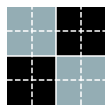

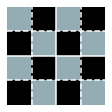

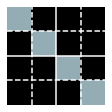

In [42]:
# Figure 6a
import copy
from statsmodels.formula.api import ols
import statsmodels.api as sm

def make_run(n,value):
    output = []
    for i in range(0,n):
        output.append(value)
    return(output)

def generate_target_matrix(k,target):

    if target == 'cdnm':
        nblocks = 2
    elif target == 'identity':
        nblocks = 4
    elif target == 'common':
        nblocks = 4
    else:
        assert False

    nrows_per_block = round(k/nblocks)

    rows = list()

    toggle_block = 1
    for ib in range(0,nblocks):

        row = []
        toggle_row = toggle_block
        for i in range(0,nblocks):

            if target == 'common':
                if i == ib:
                    row = row + make_run(nrows_per_block,1)
                else:
                    row = row + make_run(nrows_per_block,0)
            else:
                # both CDNM and identity            
                row = row + make_run(nrows_per_block,toggle_row)

            toggle_row = (1-toggle_row)
        rows.append(row)

        toggle_block = (1-toggle_block)
    target = np.tile(rows[0],(nrows_per_block,1))

    for ib in range(1,nblocks):
        block = np.tile(rows[ib],(nrows_per_block,1))
        target = np.concatenate((target,block),axis=0)

    return target


k = 16
targets = ['cdnm','identity','common']
targets_off_diag = ['cdnm','identity','common']

ntargets = len(targets)

target_matrices = list()

for it,target in enumerate(targets):
    # one of the three targets you specified
    #target_matrices.append(np.abs(generate_target_matrix(k,target)-1))
    target_matrices.append(generate_target_matrix(k,target))
off_diag_target= target_matrices[1] & ~target_matrices[2]

indices_diagonal = np.diag_indices(k)

scoring_matrices = copy.deepcopy(target_matrices)

for it,target in enumerate(targets):

    scoring_matrix = (scoring_matrices[it]).astype('float')

    # dummy value to exclude diagonal
    scoring_matrix[indices_diagonal] = 2

    # find ones / zeros, compute ratio,
    (indices_ones_rows,indices_ones_cols)   = np.where(scoring_matrix==1)
    n1 = len(indices_ones_rows)
    (indices_zeros_rows,indices_zeros_cols) = np.where(scoring_matrix==0)
    n0 = len(indices_zeros_rows)
    ratio = n0/n1
    #indices_ones[target] = [indices_ones_rows,indices_ones_cols]

    # set ones to the ratio
    scoring_matrix[indices_ones_rows,indices_ones_cols] = ratio

    # set zeros to -1 
    scoring_matrix[indices_zeros_rows,indices_zeros_cols] = -1

    # normalize so that the weights of the ones add up to 1 (same for -1)
    values = scoring_matrix[indices_ones_rows,indices_ones_cols]
    total  = np.sum(values)
    scoring_matrix = scoring_matrix / total

    #check normalization
    tmp = scoring_matrix[indices_ones_rows,indices_ones_cols]
    total_ones = np.sum(tmp)
    tmp = scoring_matrix[indices_zeros_rows,indices_zeros_cols]
    total_zeros = np.sum(tmp)
    print('target %s:\tsum_1=%1.2f\tsum_0=%1.2f' % (target,total_ones,total_zeros))

    # store
    scoring_matrices[it] = copy.deepcopy(scoring_matrix)

file_path = '/Users/maori2/Downloads/scoring_matrix_cdnm.npy'
scoring_matrices[0]=np.load(file_path)

file_path = '/Users/maori2/Downloads/scoring_matrix_identity.npy'
scoring_matrices[1]=np.load(file_path)

file_path = '/Users/maori2/Downloads/scoring_matrix_common.npy'
scoring_matrices[2]=np.load(file_path)
for i in [0,1,2]:
    
    fig, ax1 = plt.subplots(figsize=(1.8, 1.8))
    cax = ax1.imshow(target_matrices[i], cmap = 'bone', interpolation='nearest',vmin=-0, vmax=1.5 );
    plt.gca().axes.get_xaxis().set_visible(False)  # Hide x-axis ticks and labels
    plt.gca().axes.get_yaxis().set_visible(False)  # Hide x-axis ticks and labels
    
    plt.gca().spines['top'].set_visible(False)  # Hide top spine/frame
    plt.gca().spines['right'].set_visible(False)  # Hide right spine/frame
    plt.gca().spines['bottom'].set_visible(False)  # Hide bottom spine/frame
    plt.gca().spines['left'].set_visible(False)  # Hide left spine/frame
    
    ax1.axhline(y=7.5, color='w', linestyle='-')
    ax1.axvline(x=7.5, color='w', linestyle='-')
    
    ax1.axhline(y=3.5, color='w', linestyle='--')
    ax1.axvline(x=3.5, color='w', linestyle='--')
    
    ax1.axhline(y=11.5, color='w', linestyle='--')
    ax1.axvline(x=11.5, color='w', linestyle='--')
    #ax1.set_title(f'{session_title}')
    plt.show()

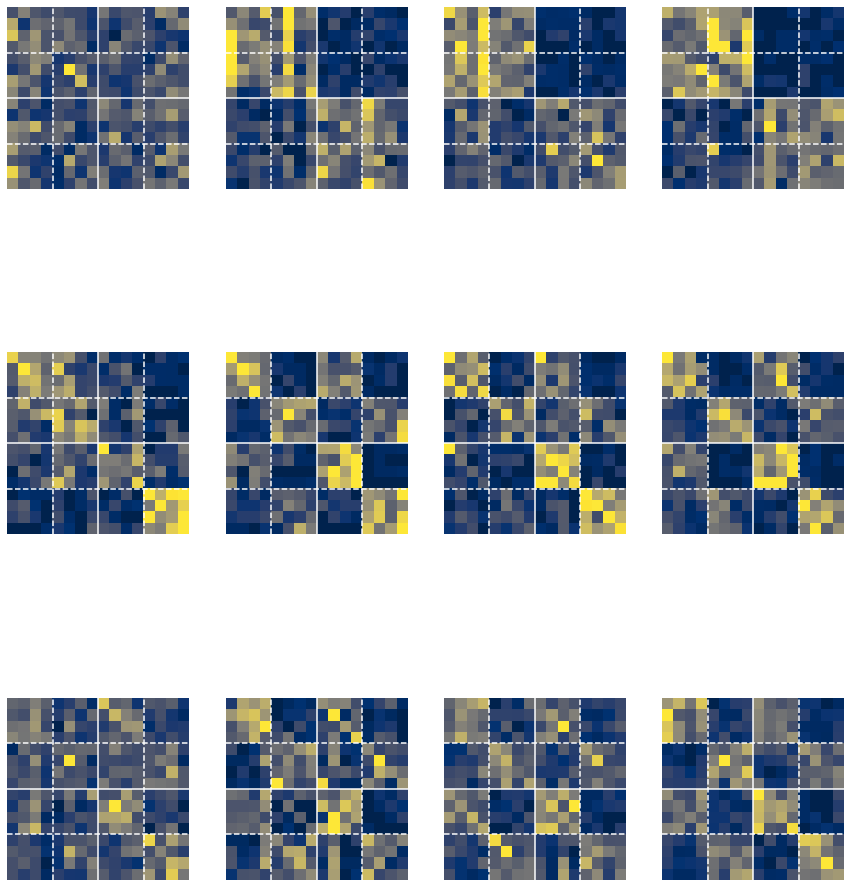

In [43]:
#Fig 6b-d
fig, axes = plt.subplots(3, 4, figsize=(15, 18))
axes_flat = axes.flatten()
for index,i in enumerate([0,4,5,9,15,19,20,24,30,34,35,39]):
    df_sessions_f=df_sessions.loc[i]
    session_title = df_sessions_f['session_title']
    session_names=df_sessions_f['session_names']
    CM=[]
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        cm_cdnm=loaded_data['SVM']['vals_and_ID']['cm']
        #cm_cdnm = loaded_data["cm_similarity_pca_epochs"]
        CM.append(cm_cdnm)
    cm_cdnm=np.mean(CM,axis=0)

    axes_flat[index].imshow(cm_cdnm, cmap = 'cividis', interpolation='nearest',vmin=0, vmax=0.2)
    axes_flat[index].axes.get_xaxis().set_visible(False)  # Hide x-axis ticks and labels
    axes_flat[index].axes.get_yaxis().set_visible(False)  # Hide x-axis ticks and labels

    axes_flat[index].spines['top'].set_visible(False)  # Hide top spine/frame
    axes_flat[index].spines['right'].set_visible(False)  # Hide right spine/frame
    axes_flat[index].spines['bottom'].set_visible(False)  # Hide bottom spine/frame
    axes_flat[index].spines['left'].set_visible(False)  # Hide left spine/frame

    axes_flat[index].axhline(y=7.5, color='w', linestyle='-')
    axes_flat[index].axvline(x=7.5, color='w', linestyle='-')

    axes_flat[index].axhline(y=3.5, color='w', linestyle='--')
    axes_flat[index].axvline(x=3.5, color='w', linestyle='--')

    axes_flat[index].axhline(y=11.5, color='w', linestyle='--')
    axes_flat[index].axvline(x=11.5, color='w', linestyle='--')

plt.show()

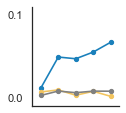

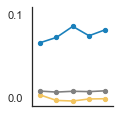

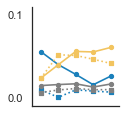

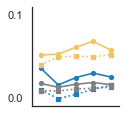

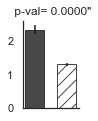

In [25]:
# Figure 6e-g
npermutations = 1000

scores_permute= dict()
scores_data= dict()
df_sim=pd.DataFrame()

df_sessions_f = df_sessions[(df_sessions.index>=0)&(df_sessions.index<40)]
CM_session=[]
for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    CM=[]
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        cm_cdnm=loaded_data['SVM']['vals_and_ID']['cm']
        #cm_cdnm = loaded_data["cm_similarity_pca_epochs"]

        #CM.append(cm_cdnm)
        #cm_cdnm=np.mean(CM,axis=0)  


        scores = np.zeros((ntargets))
        p_value = np.zeros((ntargets))
        scores_perm = np.zeros((ntargets,npermutations))
        off_diag = np.mean(cm_cdnm[off_diag_target.astype(bool)])
        in_diag = np.mean(cm_cdnm[target_matrices[2].astype(bool)])
        diag_ratio= in_diag/off_diag

        # calculate the three scores for each permutation
        for ip in range(0,npermutations):
            permutation_here = np.random.permutation(k)
            permutation_here2 = np.random.permutation(k)

            permuted_data_matrix = copy.deepcopy(cm_cdnm)
            reference_here = np.arange(0,k,dtype=int)

            permuted_data_matrix[reference_here,:] = permuted_data_matrix[permutation_here,:]
            permuted_data_matrix[:,reference_here] = permuted_data_matrix[:,permutation_here2]

            for it,target in enumerate(targets):
                scoring_matrix = scoring_matrices[it]
                target_matrix = target_matrices[it]

                tmp = np.sum(np.sum(np.multiply(scoring_matrix,permuted_data_matrix)))
                scores_perm[it,ip] = tmp
                # calculate the three scores for each real matrix
        for it,target in enumerate(targets):
            scoring_matrix = scoring_matrices[it]
            target_matrix = target_matrices[it]
            scores[it] = np.sum(np.sum(np.multiply(scoring_matrix,cm_cdnm)))
            p_value[it] = ((1+np.sum(scores_perm[it,:]>= scores[it]) )/ (1+npermutations))
            new_row = pd.DataFrame([{
                'session_name': session_name,
                'session_title': session_title,
                'session_title_idx': index,
                'cdnm_sim': scores[0],
                'disc_sim': scores[1],
                'both_sim': scores[2],
                'cdnm_sim_p': p_value[0],
                'disc_sim_p': p_value[1],
                'both_sim_p': p_value[2],
                'in_diag': in_diag,
                'off_diag': off_diag,
                'diag_ratio': diag_ratio
            }])            
            df_sim = pd.concat([df_sim, new_row], ignore_index=True)
def categorize_into_bins(value):
    bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
    labels = [1, 2, 3, 4, 5, 6, 7, 8]
    return pd.cut([value], bins=bins, labels=labels, right=False)[0]

df_sim['bin_column'] = df_sim['session_title_idx'].apply(categorize_into_bins)

color_set = ["#1a80bb", "#8cc5e3","#f2c45f","#eddca5"]
color_set = ["#1a80bb", "#f2c45f","gray"]

melted_df = pd.melt(df_sim, id_vars=[ 'session_name','session_title','session_title_idx','bin_column'], value_vars=['cdnm_sim','disc_sim','both_sim'], var_name='sim_type', value_name='sim_value')

for i in [1,2]:
    
    data = melted_df[((melted_df.bin_column==i)) ]
    
    
    g = sns.catplot(data=data, x="session_title_idx", y="sim_value", hue="sim_type", capsize=.2, palette=color_set,
                    kind="point", height=2.2, aspect=1,linestyles=["-", "-","-"],
                    linewidth=1,  # Line width
                    markers=["o", "o","o"],  # Marker shapes
                    scatter_kws={"s": 10},scale=.6,legend=False,ci=None)  # Marker size)
    g.fig.tight_layout(w_pad=1); g.set_titles(""); g.despine(left=False,bottom=False,top=True)
    g.set(ylabel='',xlabel='',xticks = [],yticks=[0,.1],title = '',ylim=(-.01,.11))
    
    plt.show()

color_set = ["#1a80bb", "#1a80bb","#f2c45f","#f2c45f",'gray','gray']

melted_df = pd.melt(df_sim, id_vars=[ 'session_name','session_title','session_title_idx','bin_column'], value_vars=['cdnm_sim','disc_sim','both_sim'], var_name='sim_type', value_name='sim_value')

for i in [4,5]:
    data = melted_df[((melted_df.bin_column==i) | (melted_df.bin_column==i+3)) ]
    data = data.copy()
    data['session_title_idx'] = data['session_title_idx'].apply(lambda x: x - 15 if x >= 30 else x)
    data['combined'] = data['sim_type'] + ' - Bin ' + data['bin_column'].astype(str)
    
    g = sns.catplot(data=data, x="session_title_idx", y="sim_value", hue="combined", dashes = "bin_column",capsize=.2, palette=color_set,
                    kind="point", height=2.2, aspect=1,estimator=np.mean,linestyles=["-", ":","-", ":","-", ":"],
                    linewidth=1,  # Line width
                    markers=["o", "s","o", "s","o", "s"],  # Marker shapes
                    scatter_kws={"s": 10},scale=.6,legend=False,ci=None)  # Marker size)
    g.fig.tight_layout(w_pad=1); g.set_titles(""); g.despine(left=False,bottom=False,top=True);
    g.set(ylabel='',xlabel='',xticks = [],yticks=[0,.1],title = '',ylim=(-.01,.11))
    plt.show()

color_set = ["k", "k"]
from scipy.stats import ttest_rel, wilcoxon
data = df_sim[((df_sim.bin_column==4) | (df_sim.bin_column==5) | (df_sim.bin_column==7) | (df_sim.bin_column==8)) ]
data = data.copy()
data['session_title_idx'] = data['session_title_idx'].apply(lambda x: x - 15 if x >= 30 else x)
data['control'] = data['session_title'].str.contains('control', case=False, na=False).astype(int)
plt.figure(figsize=(1, 1.6))
x_labels = [0, 1]
means = data.groupby('control').diag_ratio.mean()
errors = data.groupby('control').diag_ratio.sem()
grouped_values = {group: values.tolist() for group, values in data.groupby('control').diag_ratio}
plt.bar(x_labels, means, color=['k', 'w'],edgecolor='k', alpha=0.8, label='Average',    hatch=['', '//'], width=0.6,yerr=errors)
stat, p_value = mannwhitneyu(grouped_values[0], grouped_values[1], alternative='two-sided')

plt.title(f' p-val= {p_value:.4f}"')
ax = plt.gca()
plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)    

/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


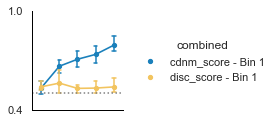

/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


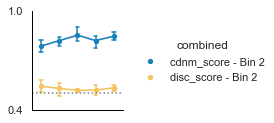

/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


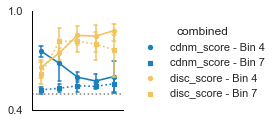

/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


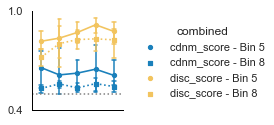

In [45]:
# Suplementary figure 4
save_path = "/Users/maori2/SchoenbaumLab Dropbox/ido maor/Mac/Documents/Lab/data/behavior/Saved_analysis/All_dataset/with_permutations"
df_scores=pd.DataFrame()
df_rats = pd.DataFrame()#initialize df for Behavioral sessions

df_sessions_f = df_sessions[(df_sessions.index>=0)&(df_sessions.index<40)]
for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']

    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict = loaded_data['behave_dict']
        filtered_dict = {k: v for k, v in behave_dict.items() if k != 'Analysis_table_mod'}
        filtered_dict['rats']=session_name[:4]
        filtered_dict['session_name'] = session_name
        filtered_dict['session_title'] = session_title
        filtered_dict['session_id'] = index
        df_temp = pd.DataFrame([filtered_dict])
        if df_rats.empty:
            df_rats = pd.DataFrame(columns=df_temp.columns)
        df_rats = pd.concat([df_rats,df_temp ], axis=0)

        cdnm_score=loaded_data['SVM']['cdnm_rule']['score']
        disc_score=loaded_data['SVM']['disc_rule']['score']
        cdnm_p=loaded_data['SVM']['cdnm_rule']['p_value']
        disc_p=loaded_data['SVM']['disc_rule']['p_value']
        cm_cdnm=loaded_data['SVM']['cdnm_rule']['cm_cdnm'][1][0]
        new_row = pd.DataFrame([{
            'session_name': session_name,
            'session_title': session_title,
            'session_title_idx': index,
            'cdnm_score': cdnm_score,
            'cdnm_p': cdnm_p,
            'disc_score': disc_score,
            'disc_p': disc_p,
            'cm_cdnm': cm_cdnm
        }])
        df_scores = pd.concat([df_scores, new_row], ignore_index=True)
 
df_rats['bin_column'] = df_rats['session_id'].apply(categorize_into_bins)
melted_df = pd.melt(df_scores, id_vars=['session_title','session_title_idx','cm_cdnm'], value_vars=['cdnm_score', 'disc_score'])
melted_df['bin_column'] = melted_df['session_title_idx'].apply(categorize_into_bins)

data=melted_df[melted_df['session_title_idx']<40]
color_set = ["#1a80bb", "#f2c45f"]
for i in [1,2]:

    data = melted_df[((melted_df.bin_column==i) ) ]
    data = data.copy()  # Create a safe copy
    data['combined'] = data['variable'] + ' - Bin ' + data['bin_column'].astype(str)

    g = sns.catplot(data=data, x="session_title_idx", y="value", hue="combined", dashes = "bin_column",capsize=.2, palette=color_set,
                    kind="point", height=2.2, aspect=1,estimator=np.mean,linestyles=["-", "-"],
                    linewidth=1,  # Line width
                    markers=["o", "o"],  # Marker shapes
                    errwidth=1.5,  # Width of error bars
                    scatter_kws={"s": 10},scale=.6)  # Marker size)
    g.fig.tight_layout(w_pad=1); g.set_titles(""); g.despine(left=False,bottom=False,top=True);g.refline(y=0.5,linestyle=":")
    g.set(ylabel='',xlabel='',xticks = [],title = '',yticks = [.4,1], ylim=(.4, 1))
    plt.show()

color_set = ["#1a80bb", "#1a80bb","#f2c45f","#f2c45f"]

for i in [4,5]:

    data = melted_df[((melted_df.bin_column==i) | (melted_df.bin_column==i+3)) ]
    data = data.copy()  # Create a safe copy

    data['session_title_idx'] = data['session_title_idx'].apply(lambda x: x - 15 if x >= 30 else x)
    data['combined'] = data['variable'] + ' - Bin ' + data['bin_column'].astype(str)

    g = sns.catplot(data=data, x="session_title_idx", y="value", hue="combined", dashes = "bin_column",capsize=.2, palette=color_set,
                    kind="point", height=2.2, aspect=1,estimator=np.mean,linestyles=["-", ":","-", ":"],
                    linewidth=1,  # Line width
                    markers=["o", "s","o", "s"],  # Marker shapes
                    errwidth=1.5,  # Width of error bars
                    scatter_kws={"s": 10},scale=.6)  # Marker size)
    g.fig.tight_layout(w_pad=1); g.set_titles(""); g.despine(left=False,bottom=False,top=True);g.refline(y=0.5,linestyle=":")
    g.set(ylabel='',xlabel='',xticks = [],title = '',yticks = [.4,1], ylim=(.4, 1))
    plt.show()

/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/seaborn/axis

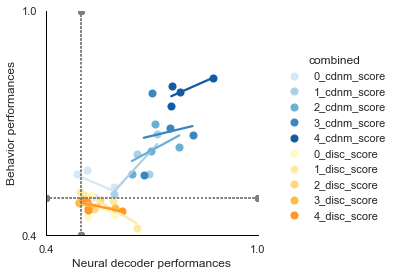

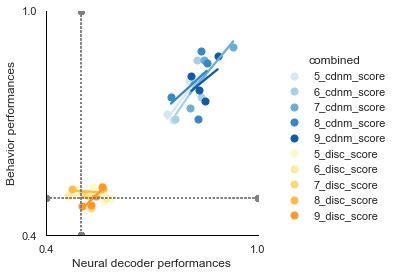

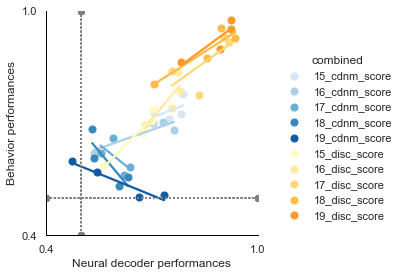

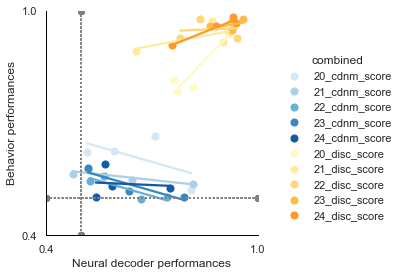

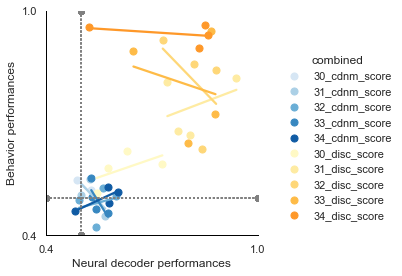

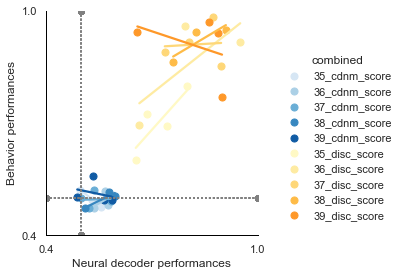

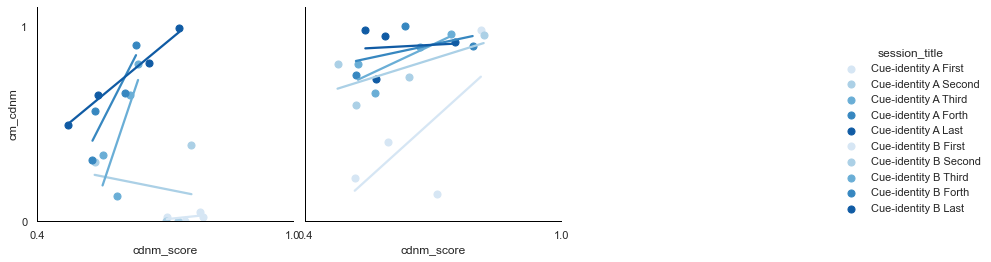

In [46]:
#Figure 7a-c
df=pd.DataFrame()
df_sessions_f = df_sessions[(df_sessions.index>=0)&(df_sessions.index<40)]
for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']

    for (session_idx, session_name) in enumerate(session_names):

        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        cdnm_score= loaded_data['SVM']['cdnm_rule']['score']
        disc_score= loaded_data['SVM']['disc_rule']['score']
        cm_cdnm   = loaded_data["SVM"]["cdnm_rule"]["cm_cdnm"][1][0]
        correct_cdnm = loaded_data["behave_dict"]["correct_cdnm"]
        correct_disc = loaded_data["behave_dict"]["correct_disc"]
        rats = session_name[:4]

        new_row = pd.DataFrame([{
            'cm_cdnm': cm_cdnm,
            'rats': rats,
            'session_name': session_name,
            'session_title': session_title,
            'session_title_idx': index,
            'cdnm_score': cdnm_score,
            'correct_cdnm': correct_cdnm,
            'disc_score': disc_score,
            'correct_disc': correct_disc
        }])        
        df = pd.concat([df, new_row], ignore_index=True)


df['bin_column'] = df['session_title_idx'].apply(categorize_into_bins)

melted_df_both1 = pd.melt(df, id_vars=[ 'rats','session_title_idx','bin_column','cm_cdnm'], value_vars=['cdnm_score','disc_score'], var_name='score_type', value_name='score_value')
melted_df_both2 = pd.melt(df, id_vars=[ 'rats','session_title_idx','bin_column','cm_cdnm'], value_vars=['correct_cdnm','correct_disc'], var_name='correct_type', value_name='correct_value')
melted_df_both = pd.concat((melted_df_both1, melted_df_both2['correct_value']),axis=1)

melted_df_both['combined'] = melted_df_both['session_title_idx'].astype(str) + '_' + melted_df_both['score_type']

melted_df_both_2 = melted_df_both.sort_values(by=['bin_column','score_type'])
blue_palette = sns.color_palette("Blues",5)
yellow_palette = sns.color_palette("YlOrBr",9)
yellow_palette=yellow_palette[0:5]
both_palettes = blue_palette+yellow_palette

#melted_df_both1 = pd.melt(df_both, id_vars=[ 'rats','session_id','bin_column','cm_cdnm'], value_vars=['cdnm_score','disc_score'], var_name='score_type', value_name='score_value')
for i in [1,2,4,5,7,8]:
    data = melted_df_both_2[((melted_df_both_2.bin_column==i) ) ]


    g = sns.lmplot(
        data=data, x="score_value", y="correct_value", hue="combined",
        palette=both_palettes, ci=None,
        height=4, scatter_kws={"s": 50, "alpha": 1}
    )
    g.set(ylabel='Behavior performances',xlabel='Neural decoder performances',xticks = [.4,1],title = '',yticks = [.4,1], ylim=(.4, 1), xlim=(.4, 1))
    g.refline(x=.5,y=0.5,linestyle=":")

df_f = df[(df.session_title_idx>=15)  & (df.session_title_idx<25)]

x_param='cdnm_score'
y_param='cm_cdnm'

g = sns.lmplot(
    data=df_f, x=x_param, y=y_param, hue="session_title",
    col="bin_column",
    col_wrap=3, palette=blue_palette, ci=None,
    height=4, scatter_kws={"s": 50, "alpha": 1}
)
g.set(ylabel=y_param,xlabel=x_param,title = '',xticks = [.4,1],yticks = [0,1], ylim=(0, 1.1), xlim=(.4, 1))

In [28]:

# Dictionary to store results
mixed_effects_results = {}
df_f = df[(df.session_title_idx!=15)&(df.session_title_idx!=16)]

# Loop through each 'bin_column' group and fit the model
for group, sub_df in df_f.groupby("bin_column"):
    if len(sub_df) > 1:  # Ensure there is enough data in each subgroup
        model = smf.mixedlm("correct_cdnm ~ cdnm_score", sub_df, groups=sub_df["session_title_idx"]).fit(method="powell")
        mixed_effects_results[group] = model.summary()

# Print results for each 'bin_column' group
for group, summary in mixed_effects_results.items():
    print(f"\n=== Mixed-Effects Model for bin_column: {group} ===")
    print(summary)

/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed


=== Mixed-Effects Model for bin_column: 1 ===
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: correct_cdnm
No. Observations: 20      Method:             REML        
No. Groups:       5       Scale:              0.0021      
Min. group size:  4       Log-Likelihood:     25.6345     
Max. group size:  4       Converged:          Yes         
Mean group size:  4.0                                     
-----------------------------------------------------------
              Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     0.225     0.164  1.367  0.172  -0.097   0.547
cdnm_score    0.571     0.226  2.523  0.012   0.127   1.015
Group Var     0.003     0.091                              


=== Mixed-Effects Model for bin_column: 2 ===
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: correct_cdnm
No. Observations: 20      Method:   

/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


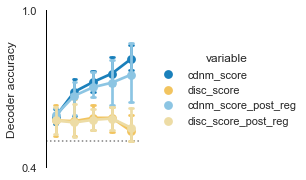

/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


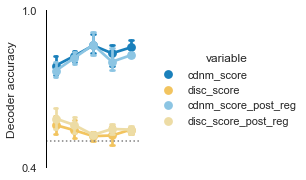

/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


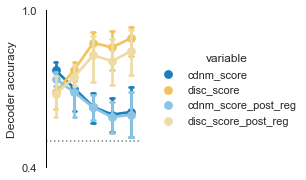

/Users/maori2/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


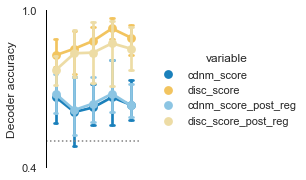

In [47]:
#Suplementary figure 4b
save_path = "/Users/maori2/SchoenbaumLab Dropbox/ido maor/Mac/Documents/Lab/data/behavior/Saved_analysis/All_dataset"

color_set = ["#1a80bb","#f2c45f", "#8cc5e3","#eddca5"]
df_scores=pd.DataFrame()
df_rats = pd.DataFrame()#initialize df for Behavioral sessions
df_sessions_f = df_sessions[(df_sessions.index>=0)&(df_sessions.index<40)]
for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']

    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict = loaded_data['behave_dict']
        filtered_dict = {k: v for k, v in behave_dict.items() if k != 'Analysis_table_mod'}
        filtered_dict['rats']=session_name[:4]
        filtered_dict['session_name'] = session_name
        filtered_dict['session_title'] = session_title
        filtered_dict['session_id'] = index
        df_temp = pd.DataFrame([filtered_dict])
        if df_rats.empty:
            df_rats = pd.DataFrame(columns=df_temp.columns)
        df_rats = pd.concat([df_rats,df_temp ], axis=0)

        cdnm_score=loaded_data['SVM']['cdnm_rule']['score']
        disc_score=loaded_data['SVM']['disc_rule']['score']
        cdnm_r=loaded_data['SVM']['cdnm_rule']['score_reg']
        disc_r=loaded_data['SVM']['disc_rule']['score_reg']
        new_row = pd.DataFrame([{
            'session_name': session_name,
            'session_title': session_title,
            'session_title_idx': index,
            'cdnm_score': cdnm_score,
            'disc_score': disc_score,
            'cdnm_score_post_reg': cdnm_r,
            'disc_score_post_reg': disc_r
        }])        
        df_scores = pd.concat([df_scores, new_row], ignore_index=True)

df_rats['bin_column'] = df_rats['session_id'].apply(categorize_into_bins)
melted_df = pd.melt(df_scores, id_vars=['session_title','session_title_idx'], value_vars=['cdnm_score', 'disc_score','cdnm_score_post_reg','disc_score_post_reg'])
melted_df['bin_column'] = melted_df['session_title_idx'].apply(categorize_into_bins)

for i in [1,2,4,5]:

    data = melted_df[((melted_df.bin_column==i) ) ]
    g = sns.catplot(data=data, x="session_title_idx", y="value", hue="variable",capsize=.2, palette=color_set, errorbar="se",sharex=False,
                    kind="point", height=3, aspect=.75,estimator=np.mean)
    g.fig.tight_layout(w_pad=1); g.set_titles(""); g.despine(left=False,bottom=True,top=True);g.refline(y=0.5,linestyle=":")
    g.set(ylabel='Decoder accuracy',xlabel='',xticks = [],title = '',yticks = [.4,1], ylim=(.4, 1))
    plt.show()

In [ ]:
#Save all analyses on files

df_sessions_f = df_sessions[df_sessions.index>=0]

for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    CM=[]
    zScore_cdnm_go = []
    zScore_cdnm_nogo = []
    zScore_disc_go = []
    zScore_disc_nogo = []

    for (session_idx, session_name) in enumerate(session_names):

        cur_session = dict_ephys[session_name]
        Analysis_table = cur_session["Analysis_table"]
        behave_dict = analyze_behave(Analysis_table)
        Analysis_table_f = behave_dict['Analysis_table_mod']
        Analysis_table_f['rats'] = session_name[:4]
        Analysis_table_f['session_name'] = session_name
        Analysis_table_f['session_title'] = session_title
        Analysis_table_f['session_id'] = index

        if Big_Analysis_table_mode.empty:
            Big_Analysis_table_mode = pd.DataFrame(columns=Analysis_table_f.columns)
        Big_Analysis_table_mode = pd.concat([Big_Analysis_table_mode,Analysis_table_f], axis=0)
        filtered_dict = {k: v for k, v in behave_dict.items() if k != 'Analysis_table_mod'}
        filtered_dict['rats']=session_name[:4]
        filtered_dict['session_name'] = session_name
        filtered_dict['session_title'] = session_title
        filtered_dict['session_id'] = index
        df = pd.DataFrame([filtered_dict])
        if df_rats.empty:
            df_rats = pd.DataFrame(columns=df.columns)
        df_rats = pd.concat([df_rats,df ], axis=0)


        spikeTime = cur_session['spikeTime']
        PETH, Trials, spikes_all = calc_PETH_equal_bins (Analysis_table_f, spikeTime , event_start = 'odor_poke' , event_end = 'odor_unpoke' , bin_num = 5)
        V_pca, exp_var = runPCA(PETH,n_components=50)
        av_LDA, cm_similarity_pca = run_Similarity(V_pca,Trials)
        B_LDA, av_LDA, cm_similarity_lda, LDA_exp_var, LDA_transformed, LDA_coef = run_LDA(V_pca,Trials)

        PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime , events = ['light_on','odor_poke','odor_time','odor_unpoke'] , resp_win = (-.2, .4),binduration=.1) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
        [V_pca_epochs, exp_var_epochs] = runPCA(PETH)
        av_LDA, cm_similarity_pca_epochs = run_Similarity(V_pca_epochs,Trials)

        PETH, Trials, spikes_all,baseline_all = calc_PETH_with_baseline(Analysis_table_f, spikeTime,events = ['odor_unpoke'],resp_win = (-2,2), binduration = .05) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)

        responsivness = calc_responsivness(Analysis_table_f,spikeTime)

        # calcilate zeta
        result_dict_Zeta = run_zeta_test(Analysis_table_f,spikeTime)

        #z score
        trials_idx = np.ones(len(Trials), dtype=bool)
        z_score_all_trials = calc_zScore (spikes_all,baseline_all,trials_idx) #for all trials

        trials_idx = Trials.cdnm_rule == True
        z_score = calc_zScore (spikes_all,baseline_all,trials_idx)
        zScore_cdnm_go.append(z_score)
        trials_idx = Trials.cdnm_rule == False
        z_score = calc_zScore (spikes_all,baseline_all,trials_idx)
        zScore_cdnm_nogo.append(z_score)

        trials_idx = Trials.disc_rule == True
        z_score = calc_zScore (spikes_all,baseline_all,trials_idx)
        zScore_disc_go.append(z_score)
        trials_idx = Trials.disc_rule == False
        z_score = calc_zScore (spikes_all,baseline_all,trials_idx)
        zScore_disc_nogo.append(z_score)

        CM.append(cm_similarity_pca)

        decoders = ['vals_and_ID','cdnm_rule','disc_rule']
        #decoders = ['cdnm_rule','disc_rule']

        df_forSVM, df_forSVM_bins = prep_for_svm(Analysis_table_f,spikeTime) # equal bins: event_start = 'odor_poke' , event_end = 'odor_unpoke' , bin_num = 5
        SVM={}
        for (decoder_id, decode_var) in enumerate(decoders):
            #[score,permutation_scores,p_value,D_df,cm] = calc_svm_with_permutation(df_forSVM,decode_var = decode_var,n_permutations=1000)
            [cm,min_reps,score_m,score_s,D_df,score_reg] = calc_svm(df_forSVM,decode_var = decode_var,reg_var = 'go_nogo')

            filtered_df = D_df.loc[(D_df['cdnm_rule'] == True) & (D_df['disc_rule'] == False), ['go_nogo', 'cdnm_rule','disc_rule','y_pred']]
            cm_cdnm = confusion_matrix(filtered_df.y_pred, filtered_df.go_nogo.astype(bool),normalize='true') #get cm for predictions Vs actual choice
            Cm_bins=[];Score_m_bins=[];Score_reg_bins=[]
            for dd in range(len(df_forSVM_bins)):
                [cm_bins,min_reps,score_m_bins,score_s_bins,D_df_bins,score_reg_bins] = calc_svm(df_forSVM_bins[dd],decode_var = decode_var,reg_var = 'go_nogo')
                Cm_bins.append(cm_bins); Score_m_bins.append(score_m_bins);Score_reg_bins.append(score_reg_bins)
            #SVM[decode_var]={'score':score,'permutation_scores':permutation_scores,'p_value':p_value,'D_df':D_df,'cm_cdnm':cm_cdnm,'cm':cm}

            SVM[decode_var]={'score':score_m,'D_df':D_df,'cm_cdnm':cm_cdnm,'cm':cm,'score_reg':score_reg,'cm_bins':Cm_bins,'score_bins':Score_m_bins,'score_reg_bins':Score_reg_bins}

        df_forSVM = prep_for_svm_pca(Analysis_table_f,spikeTime) #concatinate 4 event epochs: events = ['light_on','odor_poke','odor_time','odor_unpoke'] , resp_win = (-.2, .4),binduration=.1)
        SVM_pca={}
        for (decoder_id, decode_var) in enumerate(decoders):
 
            [cm,min_reps,score_m,score_s,D_df,score_reg] = calc_svm(df_forSVM,decode_var = decode_var,reg_var = 'go_nogo')

            filtered_df = D_df.loc[(D_df['cdnm_rule'] == True) & (D_df['disc_rule'] == False), ['go_nogo', 'cdnm_rule','disc_rule','y_pred']]
            cm_cdnm = confusion_matrix(filtered_df.y_pred, filtered_df.go_nogo.astype(bool),normalize='true') #get cm for 
            SVM_pca[decode_var]={'score':score_m,'D_df':D_df,'cm_cdnm':cm_cdnm,'cm':cm,'score_reg':score_reg}

        save_data = {'session_name': session_name,
                     'session_title': session_title,
                     'spikeTime':spikeTime,
                     'Analysis_table_f': Analysis_table_f,
                     'behave_dict':behave_dict,
                     'PETH': PETH,
                     'Trials':Trials,
                     'V_pca':V_pca,
                     'exp_var':exp_var,
                     'exp_var_epochs':exp_var_epochs,
                     'cm_similarity_pca':cm_similarity_pca,
                     'result_dict_Zeta':result_dict_Zeta,
                     'responsivness':responsivness,
                     'z_score_all_trials':z_score_all_trials,
                     'SVM':SVM,
                     }


        with open(f'{save_path}/all_data_{session_name}.pkl', 'wb') as f:
            pickle.dump(save_data, f)




In [49]:
levels= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,30,31,32,33,34,35,36,37,38,39]
for i in levels:
    df_sessions_f=df_sessions.loc[i]
    session_title = df_sessions_f['session_title']
    session_names = df_sessions_f['session_names']
    all_PETH=[]
    all_Trials=[]
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        Analysis_table_f=loaded_data['Analysis_table_f']
        spikeTime=loaded_data['spikeTime']
        PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime , events = ['odor_unpoke'] , resp_win = (-.5, 0),binduration=.1) 
        all_PETH.append(PETH)
        all_Trials.append(Trials)
    data_arrays=all_PETH
    label_dfs=all_Trials
    df=Trials
    aligned_data = {i: [] for i in range(len(data_arrays))}
    aligned_labels = []
    scaler = StandardScaler()
    normalized_data_arrays = [scaler.fit_transform(arr) for arr in data_arrays]
    data_arrays=normalized_data_arrays
    unique_labels = set.intersection(*[set(df['vals_and_ID']) for df in label_dfs])

    for label in unique_labels:
        subsets = [data_arrays[i][label_dfs[i]['vals_and_ID'] == label] for i in range(len(data_arrays)) ]
        min_count = min(len(subset) for subset in subsets)
        sampled_subsets = [            subset[np.random.choice(subset.shape[0], min_count, replace=False)] for subset in subsets        ]
        for i, sampled_subset in enumerate(sampled_subsets):
            aligned_data[i].append(sampled_subset)
        aligned_labels.extend([label] * min_count)
    aligned_data = {i: np.vstack(aligned_data[i]) for i in range(len(data_arrays))}
    result = np.hstack([aligned_data[i] for i in range(len(data_arrays))])
    result_labels = pd.DataFrame({'vals_and_ID': aligned_labels})
    PETH= result
    Trials = result_labels

    X=PETH
    y=Trials.vals_and_ID.rank(method='dense', ascending=True).astype(int) - 1
    umap_model = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=3, random_state=42)
    X_umap = umap_model.fit_transform(X)

    # Create a DataFrame with embeddings and labels
    df = pd.DataFrame(X_umap, columns=['Dim1', 'Dim2','Dim3'])
    y=Trials.vals_and_ID.rank(method='dense', ascending=True).astype(int)

    df['Label'] = y
    # Modify the DataFrame based on the condition
    df['Result'] = df['Label'].apply(
        lambda x: f"{x - 8} match" if x >= 9 else f"{x} non-match"
    )
    df['Category'] = df['Label'].apply(
        lambda x: "match" if x >= 9 else "non-match"
    )
    df['Odors'] = df['Label'].apply(
        lambda x: x - 8 if x >= 9 else x
    )

    # Compute mean embedding for each cluster
    cluster_means = df.groupby(['Category','Odors','Result'])[['Dim1', 'Dim2','Dim3']].mean()
    cluster_std = df.groupby(['Category','Odors','Result'])[['Dim1', 'Dim2','Dim3']].std()
    # Custom normalized Euclidean distance function
    def normalized_euclidean(c1, c2):
        return np.sqrt(np.sum(((c1 - c2) ** 2) / (cluster_std[0] ** 2 + cluster_std[1] ** 2)))
    distances = pdist(cluster_means, metric=lambda u, v: np.sqrt(np.sum(((u - v) ** 2) / (cluster_std ** 2).sum(axis=0)))) #The function 
    linkage_matrix = linkage(distances, method='ward')

    distance_matrix = squareform(distances)
 
    grouped = cluster_means.groupby(level=1)
    grouped_std = cluster_std.groupby(level=1)

    # Compute pairwise distances within each group
    results = {}
    #for key, group in grouped:
    #distances = pdist(group.values, metric='euclidean')
    for (key1, group1), (key2, group2) in zip(grouped, grouped_std):
        assert key1 == key2  # Ensure keys are the same
        distances_group = pdist(group1.values, metric=lambda u, v: np.sqrt(np.sum(((u - v) ** 2) / (group2.values ** 2).sum(axis=0)))) #The function 

        results[key1] = distances_group


        # Compute stats for keys 1-4
    mean_1_4, sem_1_4 = compute_stats([1, 2, 3, 4], results)
    print(f"Keys 1-4: Mean = {mean_1_4:.3f}, SEM = {sem_1_4:.3f}")

    # Compute stats for keys 5-8
    mean_5_8, sem_5_8 = compute_stats([5, 6, 7, 8], results)
    print(f"Keys 5-8: Mean = {mean_5_8:.3f}, SEM = {sem_5_8:.3f}")

    # Compute stats for keys 5-8
    mean_1_8, sem_1_8 = compute_stats([1, 2, 3, 4, 5, 6, 7, 8], results)
    print(f"Keys 1-8: Mean = {mean_1_8:.3f}, SEM = {sem_1_8:.3f}")

    to_keep = df[['Dim1','Dim2','Dim3']]
    number_permutations = 1000
    perm_mean_1_4 = [];perm_mean_5_8 = [];perm_mean_1_8 = []
    for i in range(number_permutations):
        to_permute = df[['Label','Result','Category','Odors']]
        to_permute = to_permute.sample(frac=1).reset_index(drop=True)    # Permute rows of the selected columns
        df_permute = pd.concat([ to_keep, to_permute], axis=1)
        # Compute mean embedding for each cluster
        cluster_means_p = df_permute.groupby(['Category','Odors','Result'])[['Dim1', 'Dim2','Dim3']].mean()
        cluster_std_p = df_permute.groupby(['Category','Odors','Result'])[['Dim1', 'Dim2','Dim3']].std()
        grouped = cluster_means_p.groupby(level=1)
        grouped_std = cluster_std_p.groupby(level=1)
        results = {}
        #for key, group in grouped:
        #distances = pdist(group.values, metric='euclidean')
        for (key1, group1), (key2, group2) in zip(grouped, grouped_std):
            assert key1 == key2  # Ensure keys are the same
            distances = pdist(group1.values, metric=lambda u, v: np.sqrt(np.sum(((u - v) ** 2) / (group2.values ** 2).sum(axis=0)))) #The function     
            results[key1] = distances


            # Compute stats for keys 1-4
        mean_temp, temp = compute_stats([1, 2, 3, 4], results)
        perm_mean_1_4.append(mean_temp)
        mean_temp, temp = compute_stats([5, 6, 7, 8], results)
        perm_mean_5_8.append(mean_temp)
        mean_temp, temp = compute_stats([1, 2, 3, 4, 5, 6, 7, 8], results)
        perm_mean_1_8.append(mean_temp)
    p_value_1_4 = permutation_test(mean_1_4, perm_mean_1_4, alternative="two-sided")
    p_value_5_8 = permutation_test(mean_5_8, perm_mean_5_8, alternative="two-sided")
    p_value_1_8 = permutation_test(mean_1_8, perm_mean_1_8, alternative="two-sided")
##
    df['Label'] = y
    # Modify the DataFrame based on the condition
    df['Result'] = df['Label'].apply(
        lambda x: f"{x - 8} match" if x >= 9 else f"{x} non-match"
    )
    df['Category'] = df['Label'].apply(
        lambda x: "match" if x >= 9 else "non-match"
    )
    df['Odors'] = df['Label'].apply(
        lambda x: x - 8 if x >= 9 else x
    )
    df['cue_id'] = df['Odors'].apply(
        lambda x: "nogo_odors" if x >= 5 else "go_odors"
    )

    # Compute mean embedding for each cluster
    cluster_means = df.groupby(['cue_id','Odors'])[['Dim1', 'Dim2','Dim3']].mean()
    cluster_std = df.groupby(['cue_id','Odors'])[['Dim1', 'Dim2','Dim3']].std()

    group1_mean = cluster_means.loc["go_odors"]
    group2_mean = cluster_means.loc["nogo_odors"]
    group1_std = cluster_std.loc["go_odors"]
    group2_std = cluster_std.loc["nogo_odors"]
    mean_pair= pd.concat([group1_mean.iloc[1].to_frame().T,group2_mean.iloc[1].to_frame().T])
    std_pair= pd.concat([group1_std.iloc[1].to_frame().T,group2_std.iloc[1].to_frame().T])
    distances_group=[]
    for i in range(4):
        for ii in range(4):
            mean_pair= pd.concat([group1_mean.iloc[i].to_frame().T,group2_mean.iloc[ii].to_frame().T])
            std_pair= pd.concat([group1_std.iloc[i].to_frame().T,group2_std.iloc[ii].to_frame().T])

            distances_group.append(pdist(mean_pair, metric=lambda u, v: np.sqrt(np.sum(((u - v) ** 2) / (std_pair ** 2).sum(axis=0))))) #The function 


    mean_cue_id=np.mean(distances_group)
    sem_cue_id =np.std(distances_group, ddof=1) / np.sqrt(len(distances_group))

    print(f"Keys 1-8: Mean = {mean_cue_id:.3f}, SEM = {sem_cue_id:.3f}")

    to_keep = df[['Dim1','Dim2','Dim3']]
    number_permutations = 1000
    perm_mean_cue_id = []
    for i in range(number_permutations):
        to_permute = df[['Label','Result','Category','Odors','cue_id']]
        to_permute = to_permute.sample(frac=1).reset_index(drop=True)    # Permute rows of the selected columns
        df_permute = pd.concat([ to_keep, to_permute], axis=1)
        # Compute mean embedding for each cluster
        cluster_means_p = df_permute.groupby(['cue_id','Odors'])[['Dim1', 'Dim2','Dim3']].mean()
        cluster_std_p = df_permute.groupby(['cue_id','Odors'])[['Dim1', 'Dim2','Dim3']].std()
        group1_mean = cluster_means_p.loc["go_odors"]
        group2_mean = cluster_means_p.loc["nogo_odors"]
        group1_std = cluster_std_p.loc["go_odors"]
        group2_std = cluster_std_p.loc["nogo_odors"]
        mean_pair= pd.concat([group1_mean.iloc[1].to_frame().T,group2_mean.iloc[1].to_frame().T])
        std_pair= pd.concat([group1_std.iloc[1].to_frame().T,group2_std.iloc[1].to_frame().T])
        distances_group=[]
        for i in range(4):
            for ii in range(4):
                mean_pair= pd.concat([group1_mean.iloc[i].to_frame().T,group2_mean.iloc[ii].to_frame().T])
                std_pair= pd.concat([group1_std.iloc[i].to_frame().T,group2_std.iloc[ii].to_frame().T])

                distances_group.append(pdist(mean_pair, metric=lambda u, v: np.sqrt(np.sum(((u - v) ** 2) / (std_pair ** 2).sum(axis=0))))) #The function 


        perm_mean_cue_id.append(np.mean(distances_group))

    p_value_cue_id = permutation_test(mean_cue_id, perm_mean_cue_id, alternative="two-sided")


    save_data = {
        'session_title': session_title,
        'X_umap':X_umap,#
        'Trials':Trials,#
        'cluster_means':cluster_means,#
        'linkage_matrix':linkage_matrix,#
        'cluster_std':cluster_std,#
        'distances':distances,
        'perm_mean_1_8':perm_mean_1_8,#
        'perm_mean_cue_id':perm_mean_cue_id #
    }

    # with open(f'{save_path}/UMAP_{session_title}.pkl', 'wb') as f:
    #     pickle.dump(save_data, f)

NameError: name 'umap' is not defined